# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import math

df = pd.read_csv('/datasets/real_estate_data.csv', '\t')

df.info()

print('\n \n Изучаем различные значения по отдельным полям\n')
print('Варианты значений is_apartment: {}'.format(df['is_apartment'].unique()))
print('Варианты значений balcony: {}'.format(df['balcony'].unique()))


print('Сделаем проверку на дубликаты: {} повторений.'.format(df.duplicated().sum()))

display(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21T00:00:00,3,3.70,5.0,73.3,3,NaN,...,13.83,NaN,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,NaN,5.0,38.0,4,NaN,...,8.50,NaN,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.7,1,NaN,...,NaN,NaN,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23697,13,11475000.0,76.75,2017-03-28T00:00:00,2,3.00,17.0,NaN,12,NaN,...,23.30,2.0,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0


### Вывод

#### Пропуски

По методу info() находим довольно большое количество пропусков. Оставим комментарий по каждой переменной, где есть пропуски, а также поделим их на конкретные категории.

##### Показатели, которые не слишком важны для исследования или непригодны для использования

ceiling_height          14504 non-null float64 - не слишком важный показатель, попробуем или медиану поставить или вообще не трогать

floors_total            23613 non-null float64 - не будем трогать его, качество студии или апартаментов слабо зависит от этажности. Хотя и можно предположить, что пятиэтажка - признак довольно старого дома, а одноэтажка - уровень старого домика в деревне.

balcony                 12180 non-null float64 - половина значений составляет пропуски, что очень плохо. С другой стороны, скорее всего nan - признак того, что пользователь не указал площадь балкона из-за того, что у него его попросту нет. 

is_apartment            2775 non-null object - 11% информации заполнено, даже если мы придумаем значения, этот столбец нельзя использовать. Поэтому мы не будем им пользоваться.


##### Показатели, на которые надо обратить внимание.

living_area             21796 non-null float64 - важный показатель, нужно понять, какова логика пропусков. Может, кто-то просто ничего не заполнил по метражу.

kitchen_area            21421 non-null float64 - аналогично с living_area

locality_name           23650 non-null object - место жительства, конечно, интересный показатель. По нему я могу рассчитать среднее растояние до ключевых объектов. То, что этот показатель не указан, может что-то да значить. Ознакомимся поближе с пропусками.

airports_nearest        18157 non-null float64 - будем думать

cityCenters_nearest     18180 non-null float64 - будем думать

parks_nearest           8079 non-null float64 - очень мало данных, будем думать.

ponds_nearest           9110 non-null float64 -  аналогично с parks_nearest

ponds_around3000        18181 non-null float64 - надо смотреть на пропуски

parks_around3000        18181 non-null float64 - надо смотреть на пропуски

days_exposition         20518 non-null float64 - заполнять каким-либо образом этот тип данных будет проблематично.

##### У всех переменных, которые описывают расстрояние до какого-либо объекта, примерно одинаковое количество пропусков!

### Дубликаты

Пока что дубликатов 0 штук. Проконтроллируем на этапе предобработки, чтобы так оно и оставалось.


## Шаг 2. Предобработка данных

Начнём с того, что посмотрим, где у нас не заполнены самые важные данные - жилая площадь и площадь кухни. Без них нам точно не справиться.

In [2]:
empty_home = df.loc[df['living_area'].isnull() & df['kitchen_area'].isnull()]

print('Количество пропусков одновременно в living_area и в kitchen_area - {}'.format(len(empty_home)))

Количество пропусков одновременно в living_area и в kitchen_area - 1464


##### 1464 случая,когда не описана ни жилая площадь, ни площадь кухни. Необходимо попробовать дозаполнить эти пробелы.
Если у нас есть хотя бы один из двух показателей, мы сможем придумать, как примерно восстановить пропуски.

In [3]:
full_area = df.loc[~df['living_area'].isnull() & ~df['kitchen_area'].isnull()]
#получаем общую площадь каждой квартиры
full_area['total_area'] = full_area['living_area'] + full_area['kitchen_area']

#находим отношение площади кухни к общей площади, а также жилой площади к общей площади
full_area['living/total'] = full_area['living_area'] / full_area['total_area']
full_area['kitchen/total'] = full_area['kitchen_area'] / full_area['total_area']

# получаем среднее значение отношения площади кухни к общей площади и жилой площади к общей
# а также среднее значение площади
kitchen_ratio = full_area['kitchen_area'].mean() / full_area['total_area'].mean() 
living_ratio = 1 - kitchen_ratio
total_area_mean = full_area['total_area'].mean()

print('Среднее отношение кухонной площади к общей площади - {:.2f}'.format(kitchen_ratio))
print('Среднее отношение жилой площади к общей площади - {:.2f}'.format(living_ratio))
print('Средняя площадь - {:.2f}'.format(total_area_mean))

Среднее отношение кухонной площади к общей площади - 0.23
Среднее отношение жилой площади к общей площади - 0.77
Средняя площадь - 45.16


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [4]:
def living_area_calc(row):   
    if (math.isnan(row['living_area']) == True):
        if (math.isnan(row['kitchen_area']) == True):
            return living_ratio*total_area_mean
        else:
            return (row['kitchen_area']/kitchen_ratio)*living_ratio
    else:
         return row['living_area']

def kitchen_area_calc(row):
    if (math.isnan(row['kitchen_area']) == True):
        return (row['living_area']/living_ratio)*kitchen_ratio
    else:
        return row['kitchen_area']

df['living_area'] = df.apply(living_area_calc, axis=1)
df['kitchen_area'] = df.apply(kitchen_area_calc, axis=1) 
df.info()
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             23699 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            23699 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

Заполнили пропуски для всех площадей квартир.


Теперь заполним отсутствующие поля по количеству балконов и апартаментам. По умолчанию примем пропуски в балконах как отсутствие балкона (или значение = 0), а также отсутствие данных по апартаментам как признак того, что это обычные квартиры. 


In [5]:
df['balcony'] =df['balcony'].fillna(0) 
df['is_apartment'] = df['is_apartment'].fillna(False)

Разберемся с этажностью. Максимальное количество этажей в нашей таблице - 60. 

Но вот незадача! В Санкт-петербурге очень мало высотных зданий (а это значит, что в округе ещё меньше таких), а самое высокое жилое имеет этажность равное 37 этажам. Жилых зданий в питере, у которых больше 30 этажей - штуки (первая ссылка в гугле). Посмотрим, что у нас есть по вариантам

Количество предложений в домах с этажностью больше 30 в Петербурге и округе:
32


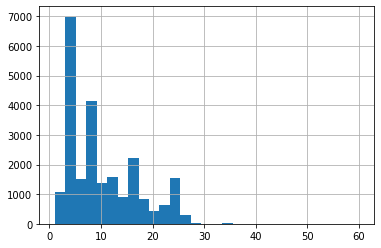

In [6]:
df['floors_total'].hist(bins=29)

print('Количество предложений в домах с этажностью больше 30 в Петербурге и округе:')
print(len(df.query('floors_total > 30')))

df = df.query('floors_total <=30')


Таких случаев очень мало, избавимся от них. 

##### Разберёмся с потолками. 
В случае с данными по потолкам, у нас нет задачи рассчитать стоимость квартиры в зависимости от их величины, поэтому постараемся обойтись без корректировки данных.

С количеством дней, по которому разместили объявления, будет довольно сложно подобрать необходимые значения.Возможно, пользователь выставил квартиру на продажу, но её всё ещё не купили из-за каких-то факторов (система). Есть два варианта, как справиться с этой проблемой: оставить всё как есть и отбрасывать эти значения при работе с данными или взять количество дней с момента публикации объявления и протянуть до сегодняшнего дня. 


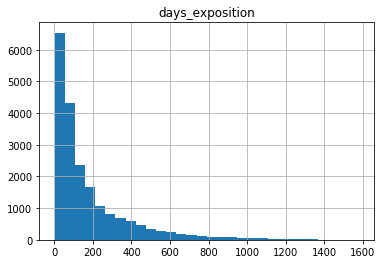

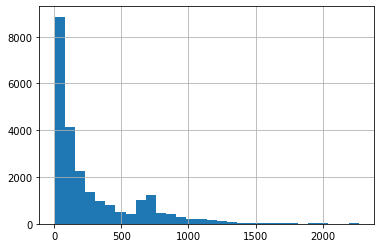

In [8]:
import matplotlib.pyplot as plt

df.hist('days_exposition', bins=30, alpha=1)

plt.show()

current_datetime = pd.to_datetime("today")

df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format="%Y-%m-%dT%H:%M:%S")


days_gone = df['days_exposition'].where(~df['days_exposition'].isnull(), (current_datetime - df['first_day_exposition']).dt.days, inplace=False)

days_gone.hist(bins=30, alpha= 1)

plt.show()

До замены значений у нас был хороший пример нормального распределения от 0 и до 1400 дней. Замена приводит к искажению нормального распределения, поэтому это плохой вариант. Попробуем проводить исследование без замены значений.

##### Теперь перейдём к разборкам с cityCenters_nearest.

Для начала переведем все значения в нижний регистр, чтобы избежать случаев, когда ошибки мешают достоверно определить значения.

In [9]:
df['locality_name'] = df['locality_name'].str.lower()

In [10]:
work_data = df.loc[df['cityCenters_nearest'].isna() == 1]
work_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5509 entries, 5 to 23698
Data columns (total 22 columns):
total_images            5509 non-null int64
last_price              5509 non-null float64
total_area              5509 non-null float64
first_day_exposition    5509 non-null datetime64[ns]
rooms                   5509 non-null int64
ceiling_height          2943 non-null float64
floors_total            5509 non-null float64
living_area             5509 non-null float64
floor                   5509 non-null int64
is_apartment            5509 non-null bool
studio                  5509 non-null bool
open_plan               5509 non-null bool
kitchen_area            5509 non-null float64
balcony                 5509 non-null float64
locality_name           5501 non-null object
airports_nearest        1 non-null float64
cityCenters_nearest     0 non-null float64
parks_around3000        1 non-null float64
parks_nearest           1 non-null float64
ponds_around3000        1 non-null floa

Гипотеза: в большинстве случаев здесь указаны какие-то деревни или поселки городского типа, слишком далекие от Петербурга.

Реальность: третья ссылка в Яндексе (методом тыка) - "поселок Бугры" в 17км от центра. Дело не в расстоянии.

Задаём себе вопросы: 

    1) Каким образом рассчитывается расстояние от квартиры до центра? 

    2) Из-за чего возникают пропуски?

Для ответа на первый вопрос необходимо обратиться к специалисту, предпоставившему данные. Но у нас нет такой возможности, поэтому пойдём рациональным путём - предположим, что человек, подающий объявление, не пишет самостоятельно расстояние. Скорее всего, он указывает адрес, а система уже самостоятельно рассчитывает расстояние до центра. 

Но что есть расстояние от дома до центра? И здесь от того, каким образом рассчитывается расстояние, зависит очень многое. Я предполагаю, что расстояние от адреса до центра - путь, который должна проделать машина из точки А в точку Б. Мне кажется, что этот вариант единственно верный, так как выссчитывать расстояние по общественному транспорту - чаще всего сложно и запаристо (и не факт, что человек будет пользоваться общественным транспортом, предпочтя личный).

На второй вопрос дать ответ сложно: очевидного предположения я найти не могу. 


Предлагаемое решение - взять среднее расстрояние по каждому населенному пункту и присвоить его все NaN'ам.

In [11]:
cityCenter_pivot = df.pivot_table(index='locality_name', values='cityCenters_nearest', aggfunc='mean')
cityCenter_pivot = cityCenter_pivot['cityCenters_nearest'].to_dict()

def cityCenter_check(row):
    if math.isnan(row['cityCenters_nearest']):
        if row['locality_name'] in cityCenter_pivot:
            return cityCenter_pivot[row['locality_name']]
        else:
            return None
    else:
        return row['cityCenters_nearest']

work_data['cityCenters_nearest'] = work_data.apply(cityCenter_check, axis=1)

work_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5509 entries, 5 to 23698
Data columns (total 22 columns):
total_images            5509 non-null int64
last_price              5509 non-null float64
total_area              5509 non-null float64
first_day_exposition    5509 non-null datetime64[ns]
rooms                   5509 non-null int64
ceiling_height          2943 non-null float64
floors_total            5509 non-null float64
living_area             5509 non-null float64
floor                   5509 non-null int64
is_apartment            5509 non-null bool
studio                  5509 non-null bool
open_plan               5509 non-null bool
kitchen_area            5509 non-null float64
balcony                 5509 non-null float64
locality_name           5501 non-null object
airports_nearest        1 non-null float64
cityCenters_nearest     69 non-null float64
parks_around3000        1 non-null float64
parks_nearest           1 non-null float64
ponds_around3000        1 non-null flo

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


Когда мы взяли только пропуски в "cityCenters_nearest", мы получили 4650 значений. С учетом всей работы мы заполнили 50 значений, что довольно мало. 

Получается, что пропуски были уникальными значениями, которые мы не можем восполнить.


##### Почему без лемматизации и стемматизации.

В случае с наименованием городов, поселков и прочее будет гораздо сложнее применить лемматизацию и сравнение из-за того, что мы точно не знаем, в области есть один поселок Иваново или их несколько. А любая ошибка такого рода может исказить данные, что навредит исследованию.

### Преобразование типа переменных

In [12]:
df['floors_total'] = df['floors_total'].astype(int)
df['balcony'] = df['balcony'].astype(int)

В данных о балконах, а также количестве этажей изменим тип значений на целочисленный.

Для других переменных, которые можно было бы преобразовать в целочисленный тип (к примеру, количество парков и озер), присутствуют пропуски, в связи с чем перевод в int невозможен.

А теперь посмотрим на количество дубликатов, оставшеесь после преобразований, совершенных с датафреймом.

In [13]:
print('Количество дубликатов - {}'.format(df.duplicated().sum()))

Количество дубликатов - 0


## Шаг 3. Посчитайте и добавьте в таблицу

Добавим сведения о цене квадратного метра.

In [14]:
df['squared_price'] = df['last_price']/df['total_area']

Теперь добавим день, месяц и год публикации.

In [15]:
df['exposition_day'] = df['first_day_exposition'].dt.day
df['exposition_month'] = df['first_day_exposition'].dt.month
df['exposition_year'] = df['first_day_exposition'].dt.year


Сейчас найдём категорию этажей: последний, первый или другой.

In [16]:
def categorize_floor(row):
    if row['floors_total'] == 1 or row['floor'] == 1:
        return "первый"
    if row['floors_total'] == row['floor']:
        return "последний"
    return "другое"

df['fl_cat'] = df.apply(categorize_floor, axis=1)


Найдём соотношение жилой площади к общей, а также кухни к жилой площади.

In [17]:
df['living_to_total'] = df['living_area']/df['total_area']

df['kitchen_to_total'] = df['kitchen_area']/df['total_area']

А тепер посмотрим на обновленный датафрейм

In [18]:
display(df)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,squared_price,exposition_day,exposition_month,exposition_year,fl_cat,living_to_total,kitchen_to_total
0,20,13000000.0,108.00,2019-03-07,3,2.70,16,51.000000,8,False,...,2.0,755.0,NaN,120370.370370,7,3,2019,другое,0.472222,0.231481
1,7,3350000.0,40.40,2018-12-04,1,NaN,11,18.600000,1,False,...,0.0,NaN,81.0,82920.792079,4,12,2018,первый,0.460396,0.272277
2,10,5196000.0,56.00,2015-08-20,2,NaN,5,34.300000,4,False,...,2.0,574.0,558.0,92785.714286,20,8,2015,другое,0.612500,0.148214
3,0,64900000.0,159.00,2015-07-24,3,NaN,14,34.644380,9,False,...,3.0,234.0,424.0,408176.100629,24,7,2015,другое,0.217889,0.066145
4,2,10000000.0,100.00,2018-06-19,2,3.03,14,32.000000,13,False,...,1.0,48.0,121.0,100000.000000,19,6,2018,другое,0.320000,0.410000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21,3,3.70,5,73.300000,3,False,...,3.0,381.0,NaN,72490.845228,21,3,2017,другое,0.547792,0.103356
23695,14,3100000.0,59.00,2018-01-15,3,NaN,5,38.000000,4,False,...,NaN,NaN,45.0,52542.372881,15,1,2018,другое,0.644068,0.144068
23696,18,2500000.0,56.70,2018-02-11,2,NaN,3,29.700000,1,False,...,NaN,NaN,NaN,44091.710758,11,2,2018,первый,0.523810,0.159013
23697,13,11475000.0,76.75,2017-03-28,2,3.00,17,76.753354,12,False,...,3.0,196.0,602.0,149511.400651,28,3,2017,другое,1.000044,0.303583


> **<span style="color:green">По этим блокам у меня нет замечаний, все по делу.</span>**


## Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

Посмотрим внимательнее на отдельные переменные. Для это выделим новый датафрейм из основного.

In [19]:
wip_data = df[['last_price', 'squared_price', 'rooms','total_area', 'living_area', 'kitchen_area', 'living_to_total', 'kitchen_to_total', 'ceiling_height' ]]

#### Вспомогательные функции

В связи с тем, что нам придётся работать с большим количеством графиков, а также строить множество сводных таблиц, я решил ввести некоторые функции, с которыми жизнь должна стать попроще.

In [20]:
def MMC_pivot(function, func_index, func_values, func_return=0, show = 1):
    '''Функция получения сводной таблицы
    
    Выводит на экран сводную таблицу'''
    got_func = function.pivot_table(index=[func_index], values=[func_values], aggfunc=['mean', 'median', 'count'])
    if show == 1:
        display(got_func)
    if func_return == 0:
        return None
    else:
        return got_func
    

In [21]:
def display_hist(df_hist,hist_title, hist_xlabel, hist_ylabel="Объем, ед."
                 ,hist_range=None, hist_size=(10,7), hist_bins=10, hist_dpi=160):
    '''Печатает красивую гистограмму.
    
    Позволяет сократить объемы текста, выводя красивую гистограмму одной строчкой'''
    plt.figure(figsize=hist_size, dpi=hist_dpi)
    plt.xlabel(hist_xlabel)
    plt.ylabel(hist_ylabel)
    plt.title(hist_title)
    plt.grid()
    plt.hist(df_hist,bins=hist_bins, range=hist_range)
    plt.show()
    plt.close()
    

In [22]:
def display_plot(df_plot, plot_xlabel, plot_ylabel, plot_title, plot_dpi=160, plot_size=(10,7)):
    plt.figure(figsize=plot_size, dpi=plot_dpi)
    plt.xlabel(plot_xlabel)
    plt.ylabel(plot_ylabel)
    plt.title(plot_title)
    plt.plot(df_plot)
    plt.show()
    plt.close()

In [23]:
def display_boxplot(figure, boxplot_title, column=None, boxplot_by=None, boxplot_figsize= (9,7), boxplot_dpi=160,
                    showfliers=False):
    plt.figure(figsize=boxplot_figsize, dpi=boxplot_dpi)
    figure.boxplot(column, by=boxplot_by, figsize=(9,7), showfliers=showfliers)
    plt.title(boxplot_title)
    plt.show()
    plt.close()

In [24]:
def display_scatter(x,y, s_title, s_xlabel, s_ylabel, dpi=160, figsize=(9,7), alpha=1):
    plt.figure(figsize=figsize, dpi=dpi)
    # В случае с scatter никак не получалось вывести нормально xlabel и ylabel, использовал знания со stackoverflow
    plt.gca().update(dict(title=s_title, xlabel=s_xlabel, ylabel=s_ylabel))
    plt.scatter(x,y, alpha=alpha)
    plt.show()
    plt.close()    

In [25]:
def compare_hist(df_hist1, df_hist2,hist_title, hist_xlabel, hist_ylabel="Объем, ед."
                 ,hist_range=None, hist_size=(10,7), hist_bins=10, hist_dpi=160, label1='central', label2='overall'):
    plt.figure(figsize=hist_size, dpi=hist_dpi)
    plt.xlabel(hist_xlabel)
    plt.ylabel(hist_ylabel)
    plt.title(hist_title)
    plt.grid()
    plt.hist(df_hist1,bins=hist_bins, range=hist_range, alpha=0.5, label=label1)
    plt.hist(df_hist2,bins=hist_bins, range=hist_range, alpha=0.5, label=label2)
    plt.legend(loc='upper right')
    plt.show()
    plt.close()

### Рассматриваем различные факторы, влияющие на стоимость квартиры

#### Количество комнат

,mean,median,count
,last_price,last_price,last_price
rooms,,,
0,3.342665e+06,2700000.0,192
1,3.834120e+06,3600000.0,8006
2,5.584735e+06,4750000.0,7897
3,8.171991e+06,6200000.0,5790
4,1.340960e+07,9000000.0,1177
5,2.379830e+07,14000000.0,325
6,3.188004e+07,19000000.0,104
7,5.147007e+07,24900000.0,59


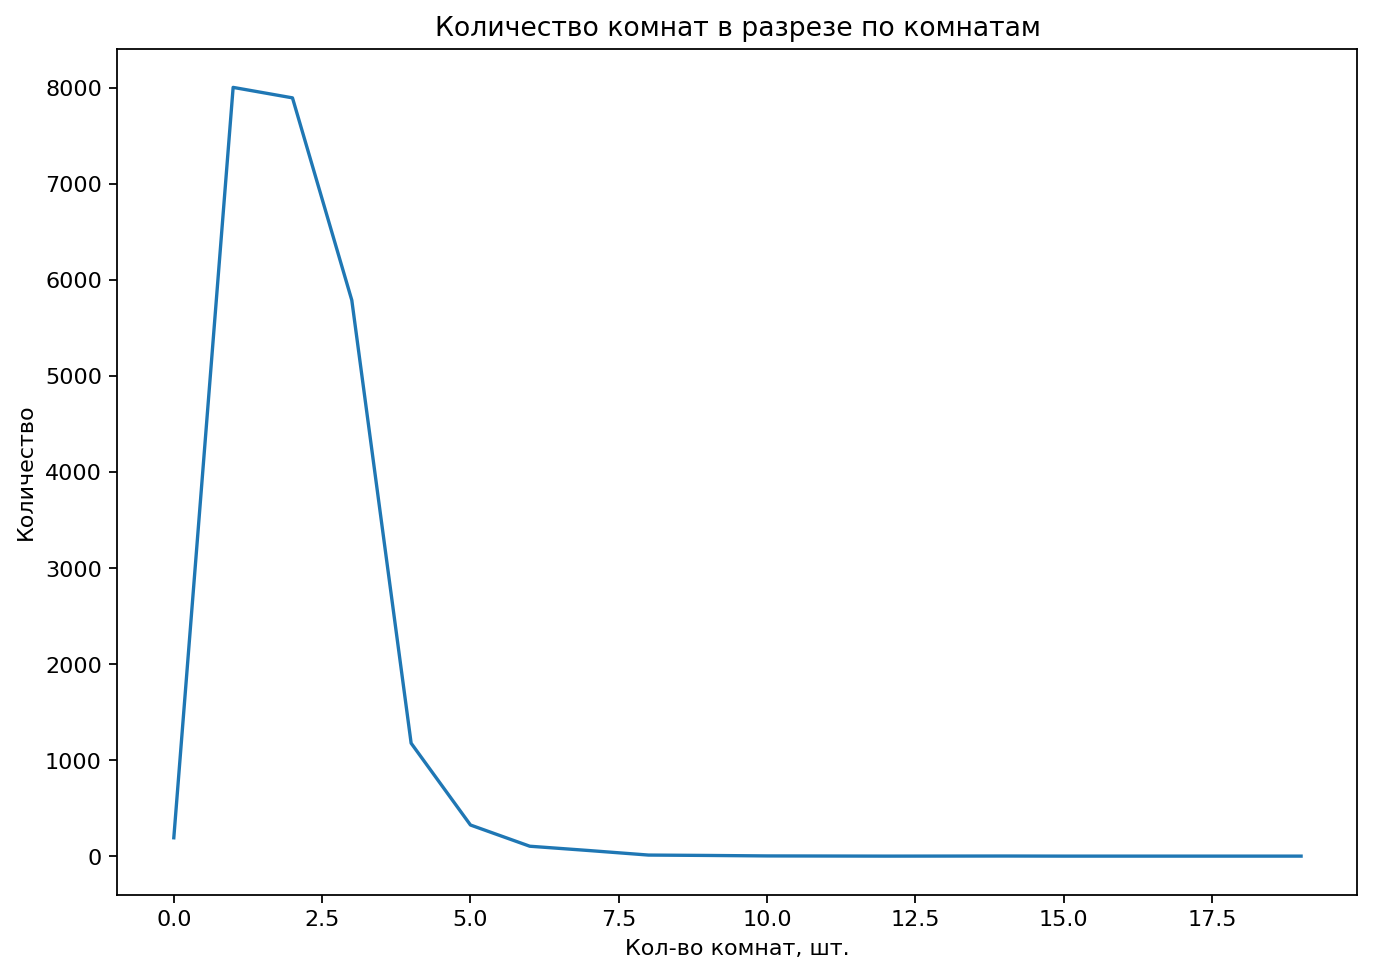

In [26]:
rooms_pivot = MMC_pivot(df, 'rooms', 'last_price', func_return=1)

display_plot(rooms_pivot['count', 'last_price'], plot_xlabel='Кол-во комнат, шт.', plot_ylabel="Количество", 
             plot_title="Количество комнат в разрезе по комнатам")

Методом describe выяснили, что у 75% объявлений стоимость цены не более 6.8 миллионов рублей.

По количеству комнат видим, что большинство квартир имеет до трёх комнат. Совсем незначительное количество комнат начинатеся с 8-комнатных квартир. 

В рамках исследования уместно взять данные по предложениям, где количество комнат будет соответствовать ожиданиям среднестатистического жителя России. 

Поэтому я принимаю решение использовать только информацию о квартирах, в которых комнат 5 или меньше. 

Из графика вылезли странные квартиры с нулём комнат, посмотрим на них.

In [27]:
zero_rooms = df.query('rooms == 0')

display(zero_rooms)

zero_rooms['is_apartment'].unique()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,squared_price,exposition_day,exposition_month,exposition_year,fl_cat,living_to_total,kitchen_to_total
144,1,2450000.0,27.00,2017-03-30,0,NaN,24,15.50000,2,False,...,NaN,NaN,181.0,90740.740741,30,3,2017,другое,0.574074,0.174272
349,4,2320000.0,25.00,2017-09-27,0,NaN,14,17.00000,1,False,...,NaN,NaN,45.0,92800.000000,27,9,2017,первый,0.680000,0.206427
440,8,2480000.0,27.11,2018-03-12,0,NaN,17,24.75000,4,False,...,2.0,982.0,64.0,91479.158982,12,3,2018,другое,0.912947,0.277143
508,0,3375000.0,34.40,2017-03-28,0,NaN,26,24.30000,19,False,...,1.0,593.0,430.0,98110.465116,28,3,2017,другое,0.706395,0.214440
608,2,1850000.0,25.00,2019-02-20,0,NaN,10,34.64438,7,False,...,NaN,NaN,29.0,74000.000000,20,2,2019,другое,1.385775,0.420679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23210,7,3200000.0,26.00,2017-09-01,0,NaN,25,18.00000,16,False,...,1.0,623.0,14.0,123076.923077,1,9,2017,другое,0.692308,0.210164
23442,0,2500000.0,27.70,2017-09-28,0,NaN,24,18.00000,4,False,...,NaN,NaN,4.0,90252.707581,28,9,2017,другое,0.649819,0.197266
23554,15,3350000.0,26.00,2018-09-07,0,NaN,19,34.64438,8,False,...,2.0,112.0,31.0,128846.153846,7,9,2018,другое,1.332476,0.404500
23592,10,1450000.0,29.00,2017-11-11,0,NaN,9,18.00000,8,False,...,NaN,NaN,82.0,50000.000000,11,11,2017,другое,0.620690,0.188423


array([False])

Проверили, они все - квартиры с довольном маленькой площадью. То есть скорее всего это студии, где жилая площадь + кухня - одно пространство. Логичнее было бы считать их однокомнатными квартирами, надо сообщить об этом специалисту. Но делать с ними пока ничего не будем. 

#### Общая цена квартиры

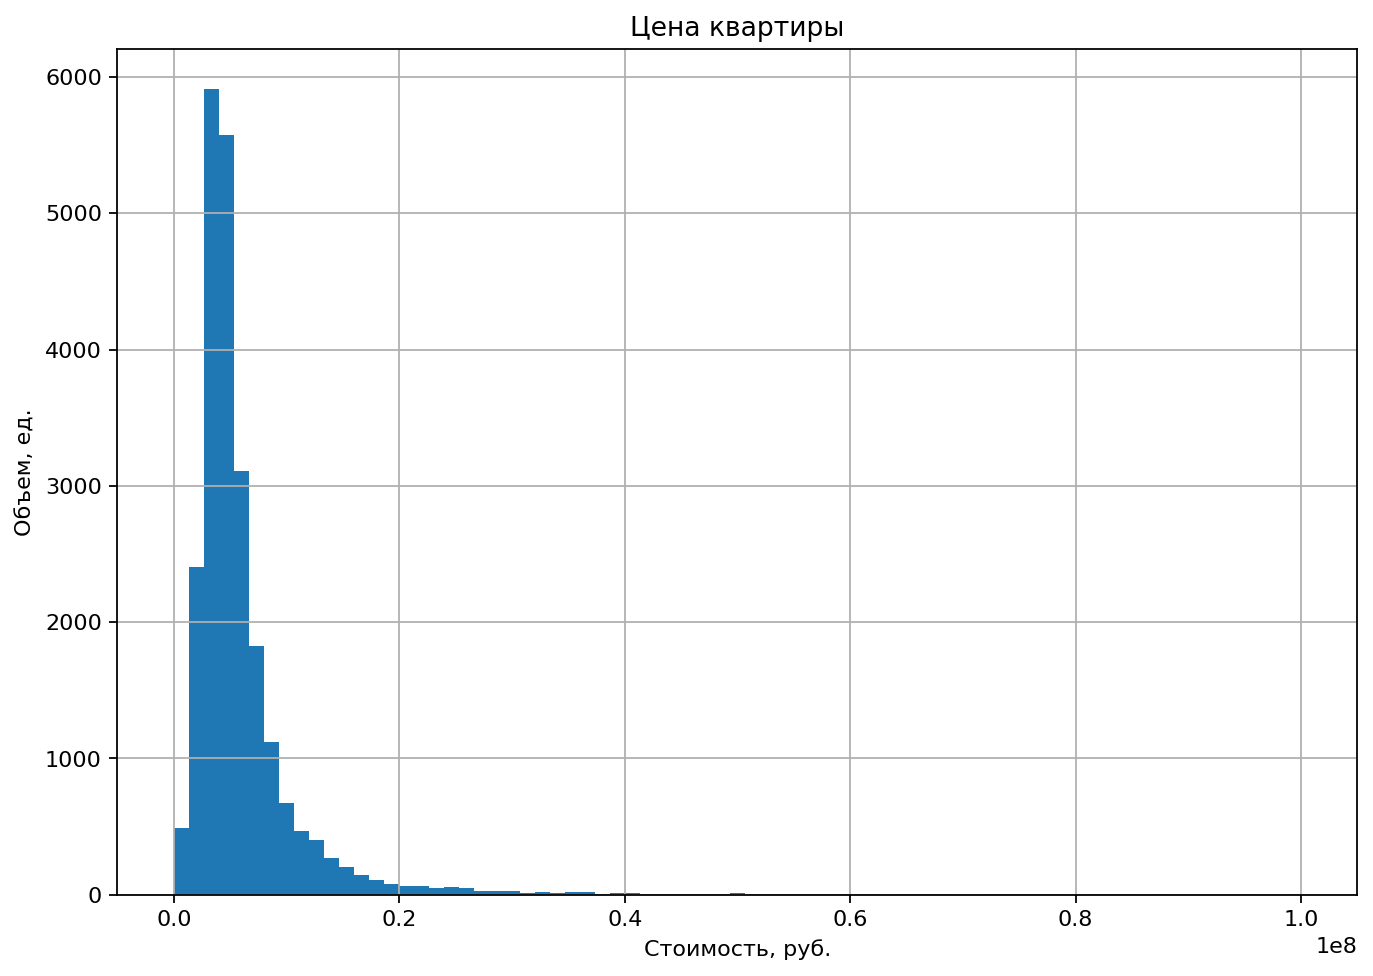

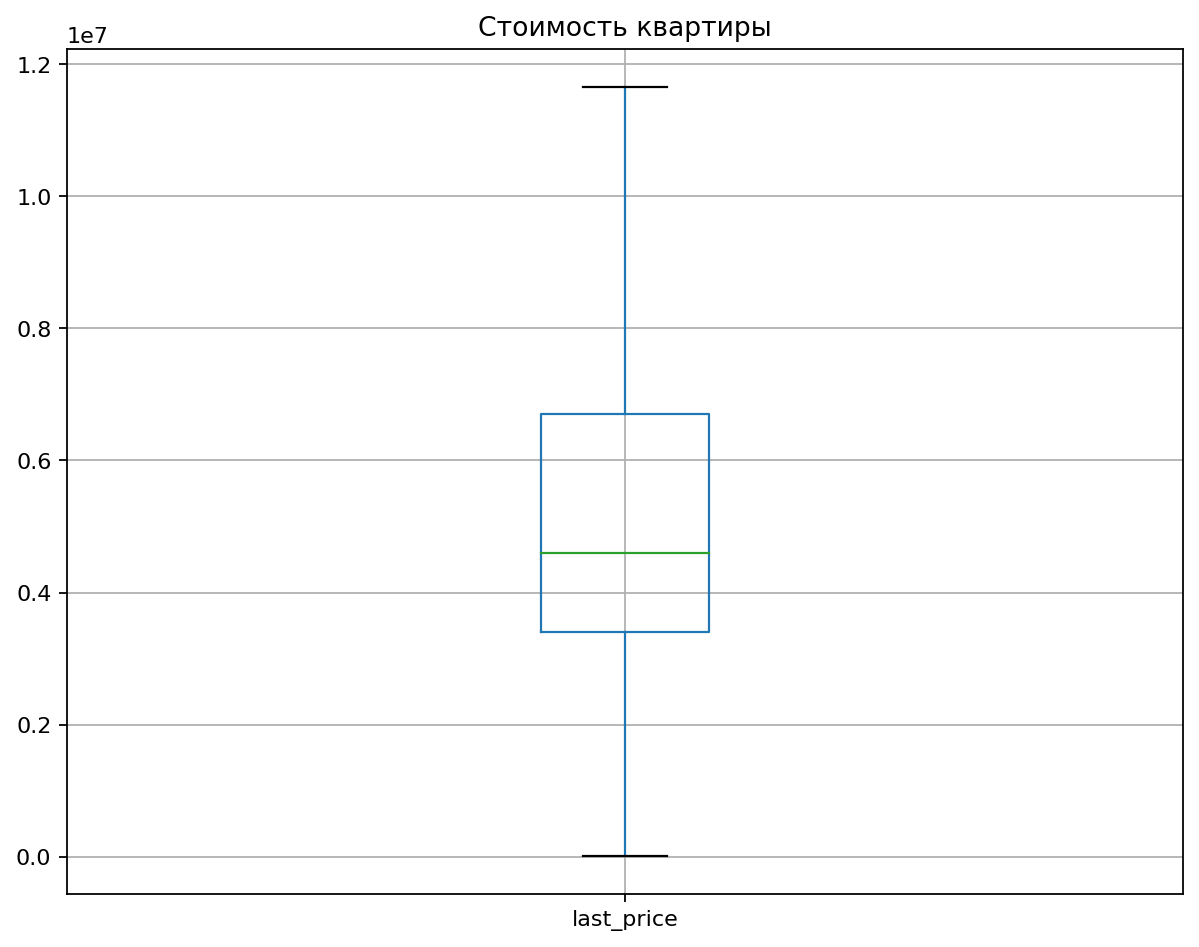

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,squared_price,exposition_day,exposition_month,exposition_year,fl_cat,living_to_total,kitchen_to_total
8793,7,12190.0,109.0,2019-03-20,2,2.75,25,32.00000,25,False,...,0.0,NaN,8.0,111.834862,20,3,2019,последний,0.293578,0.371560
14911,5,430000.0,54.0,2018-06-26,2,NaN,3,34.64438,3,False,...,NaN,NaN,44.0,7962.962963,26,6,2018,последний,0.641563,0.194759
17456,7,430000.0,30.4,2019-04-22,1,NaN,2,16.00000,1,False,...,NaN,NaN,NaN,14144.736842,22,4,2019,первый,0.526316,0.197368
16274,18,440000.0,40.0,2018-07-10,1,NaN,5,34.64438,1,False,...,NaN,NaN,45.0,11000.000000,10,7,2018,первый,0.866110,0.262925
9581,7,450000.0,43.4,2018-08-31,2,NaN,5,30.30000,3,False,...,NaN,NaN,96.0,10368.663594,31,8,2018,другое,0.698157,0.126728
17676,0,450000.0,36.5,2018-02-01,1,NaN,5,17.30000,4,False,...,NaN,NaN,120.0,12328.767123,1,2,2018,другое,0.473973,0.232877
16219,14,450000.0,38.5,2018-07-11,2,2.65,2,34.64438,1,False,...,NaN,NaN,45.0,11688.311688,11,7,2018,первый,0.899854,0.273169
5698,7,450000.0,42.0,2017-07-31,2,NaN,1,23.00000,1,False,...,NaN,NaN,233.0,10714.285714,31,7,2017,первый,0.547619,0.138095
18867,1,470000.0,41.0,2018-02-11,1,NaN,5,32.00000,3,False,...,NaN,NaN,46.0,11463.414634,11,2,2018,другое,0.780488,0.219512
21912,0,470000.0,37.0,2018-02-18,1,NaN,3,34.64438,3,False,...,NaN,NaN,45.0,12702.702703,18,2,2018,последний,0.936335,0.284243


count    2.338600e+04
mean     6.254758e+06
std      8.165377e+06
min      4.300000e+05
25%      3.400000e+06
50%      4.600000e+06
75%      6.700000e+06
max      4.013000e+08
Name: last_price, dtype: float64

In [28]:
wip_data = df.query('rooms <= 5')

display_hist(wip_data['last_price'], hist_xlabel = "Стоимость, руб.",
             hist_bins=75, hist_title= "Цена квартиры", hist_range=(0,100000000))

display_boxplot(wip_data, column='last_price', boxplot_title="Стоимость квартиры")



display(wip_data.sort_values(by='last_price', ascending=True).head(10))

wip_data = wip_data.query('last_price > 100000')

wip_data['last_price'].describe()

Наименьшее значение - 12190 руб. за квартиру. Такое значение одно на всю таблицу, все остальные данные начинаются от 430 тыс. руб. Уберём выдающееся значение.

Стандартно квартиры в петербурге стоят от 3,5 до 7 миллионов руб., в случае с дорогими квартирами цена может дойти и до 12 млн. рублей. Всё, что выше этой цены - это уже люкс или, можнт, квартира в центре. 
При этом средня стоимость квартиры 6.25 млн. руб., а медиана 4.6 млн. 

Пока что это всё, что мы можем вынуть из цены без оглядки на другие факторы.

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


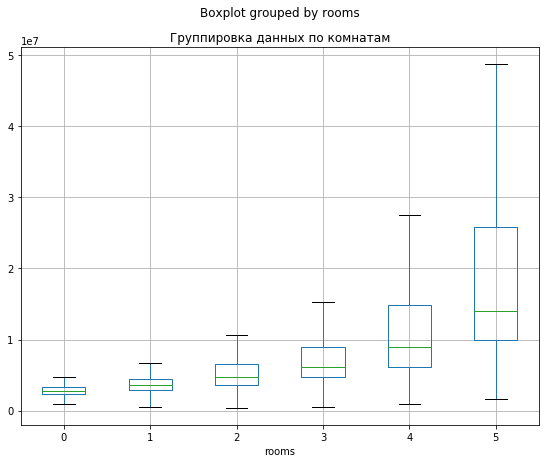

Корреляция по Пирсону: 0.352515


In [29]:
#wip_data.plot(x='rooms', y = 'last_price',kind='scatter', alpha = 0.25)

wip_data.boxplot('last_price', by='rooms', figsize=(9,7), showfliers=False)
plt.title("Группировка данных по комнатам")
plt.show()

print("Корреляция по Пирсону: {:2f}".format(wip_data['last_price'].corr(wip_data['rooms'])))

По Пирсону корелляция между стоимостью квартиры и количеством комнат прямой нет. Возможно, всё дело в том, что количество не всегда ведет к общему увеличению жилой площади. Но график показывает, что с увеличением числа комнат растёт и максимальная стоимость квартиры.

Отдельно отметим то, что минимальная стоимость квартир находится примерно на одном уровне. В данном случае на стоимость квартиры влияют другие факторы.

##### Обработка выбросов для стоимости квартир

Рассмотрим аномальные значения для фактора стоимости квартиры.

In [30]:
def quantile_calc(data):
    q_total_area =  data.quantile([0.25, 0.5, 0.75])
    q_total_area = q_total_area.to_dict()

    area_IQR = q_total_area[0.75] - q_total_area[0.25]
    q_lower_bord = q_total_area[0.25] - (1.5 * area_IQR)
    q_higher_bord = q_total_area[0.75] + (1.5 *area_IQR)

    print('Словарь перцентилей: {}'.format(q_total_area))
    print('IQR - {:.2f}'.format(area_IQR))
    print('Нижняя граница межквартильного размаха - {:.2f}'.format(q_lower_bord))
    print('Верхняя граница межквартильного размаха - {:.2f}'.format(q_higher_bord))
    return q_lower_bord, q_higher_bord
    
lower_bord_price, higher_bord_price = quantile_calc(wip_data['last_price'])

Словарь перцентилей: {0.25: 3400000.0, 0.5: 4600000.0, 0.75: 6700000.0}
IQR - 3300000.00
Нижняя граница межквартильного размаха - -1550000.00
Верхняя граница межквартильного размаха - 11650000.00


Посмотрим на выходящие за границу значения.

In [31]:
high_price_data = wip_data.query('last_price > @higher_bord_price')
display(high_price_data)
print(higher_bord_price)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,squared_price,exposition_day,exposition_month,exposition_year,fl_cat,living_to_total,kitchen_to_total
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.000000,8,False,...,2.0,755.0,NaN,120370.370370,7,3,2019,другое,0.472222,0.231481
3,0,64900000.0,159.0,2015-07-24,3,NaN,14,34.644380,9,False,...,3.0,234.0,424.0,408176.100629,24,7,2015,другое,0.217889,0.066145
19,16,14200000.0,121.0,2019-01-09,3,2.75,16,76.000000,8,False,...,0.0,NaN,97.0,117355.371901,9,1,2019,другое,0.628099,0.099174
35,6,15500000.0,149.0,2017-06-26,5,NaN,5,104.000000,4,False,...,1.0,779.0,644.0,104026.845638,26,6,2017,другое,0.697987,0.114094
42,13,22000000.0,161.8,2015-07-08,4,2.80,4,80.900000,2,False,...,1.0,907.0,987.0,135970.333745,8,7,2015,другое,0.500000,0.108776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23574,14,64990000.0,139.0,2015-11-24,3,3.00,8,3.000000,8,False,...,3.0,100.0,280.0,467553.956835,24,11,2015,последний,0.021583,0.115108
23587,7,12100000.0,88.0,2017-07-07,3,NaN,10,46.117895,5,False,...,2.0,359.0,200.0,137500.000000,7,7,2017,другое,0.524067,0.159091
23608,22,14000000.0,80.0,2017-11-10,3,NaN,11,44.100000,6,False,...,1.0,232.0,19.0,175000.000000,10,11,2017,другое,0.551250,0.137500
23631,17,14799000.0,104.0,2018-11-18,3,3.10,4,66.000000,2,False,...,1.0,553.0,90.0,142298.076923,18,11,2018,другое,0.634615,0.134615


11650000.0


Огромное количество значений, превышающих верхнюю границу "усов". Посмотрим поближе на значения.

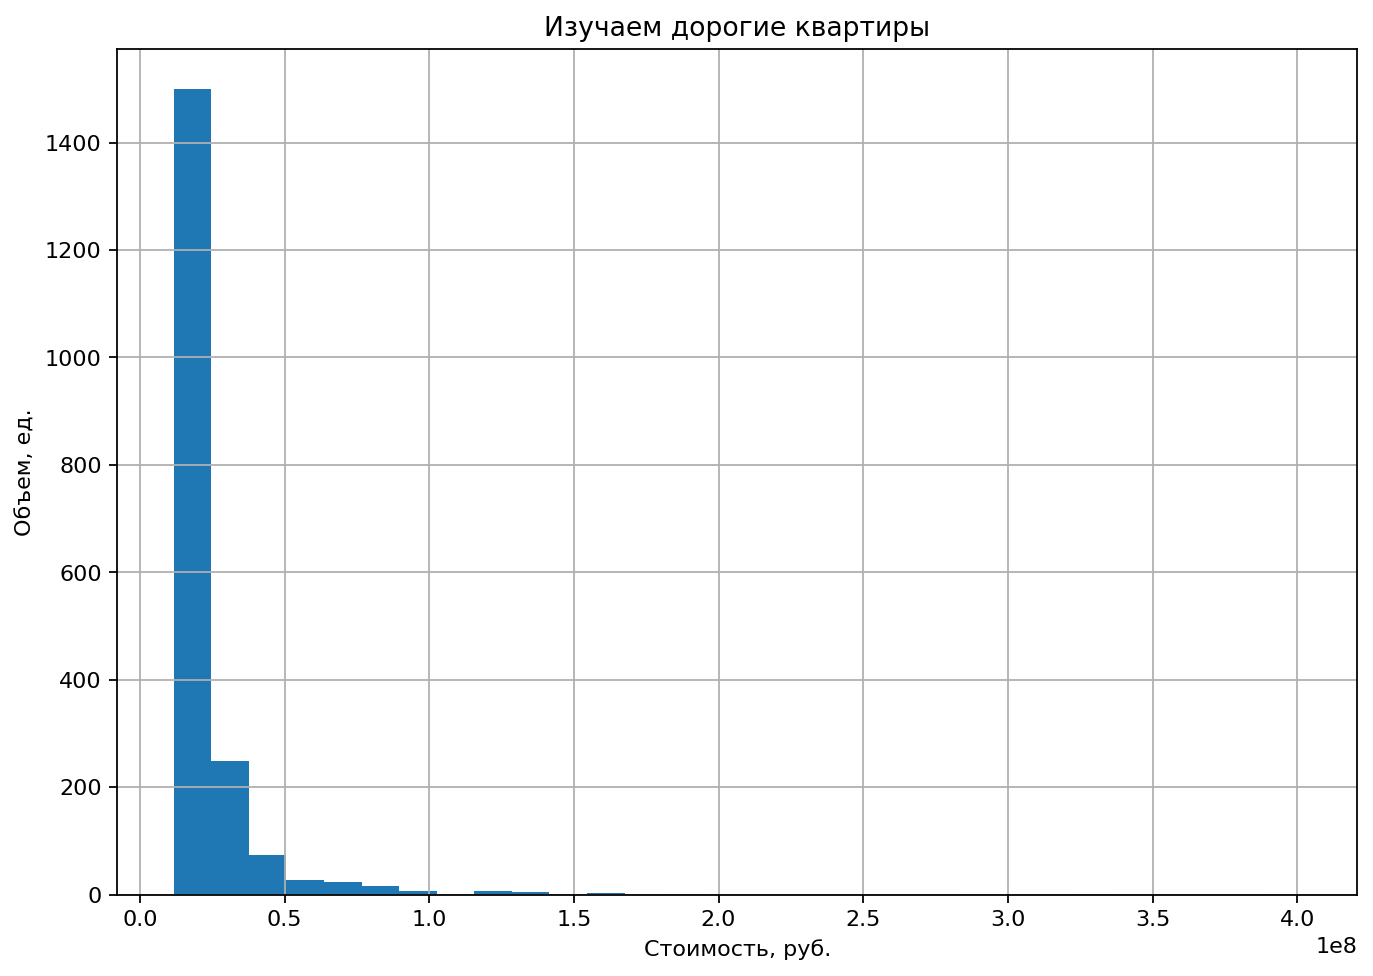

In [32]:
display_hist(high_price_data['last_price'], hist_title="Изучаем дорогие квартиры", hist_bins=30, hist_xlabel="Стоимость, руб.")

После 50 млн. руб. резко падает количество объявлений. Поэтому возьмём все объявления до 50 млн. руб.

In [33]:
wip_data = wip_data.query('last_price < 50000000')

#### Общая площадь

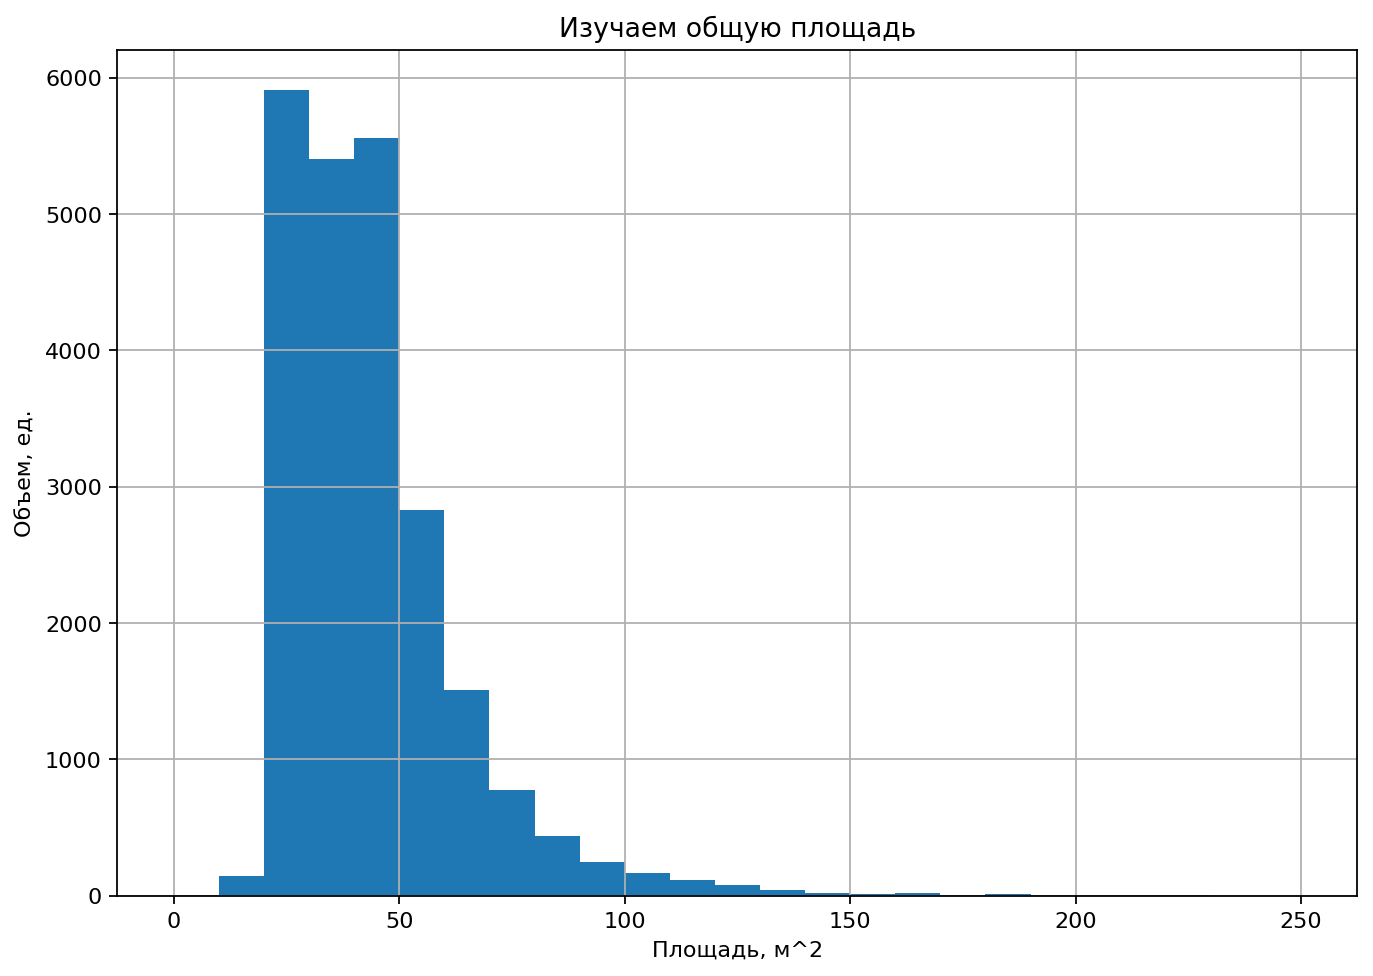

count    23281.000000
mean        43.689699
std         19.627407
min          2.607140
25%         29.300000
50%         40.100000
75%         51.000000
max        288.700000
Name: total_area, dtype: float64

In [34]:
# необходимое исправление
df['total_area'] = df['kitchen_area'] + df['living_area']
wip_data['total_area'] = wip_data['kitchen_area'] + wip_data['living_area']

display_hist(wip_data['total_area'], hist_title="Изучаем общую площадь", hist_xlabel="Площадь, м^2",
             hist_bins=25, hist_range=(0,250))

wip_data['total_area'].describe()

Подавляющее большинство квартир имеют площадь вплоть до 100 метров. Наибольее популярен варианты с площадью от 30 до 40 и от 40 до 50 метров. 

При этом медиана имеет значение в 52, а 25-ый перцентиль - 40, что очень недалеко. То есть редко когда мы увидим квартиру меньше 30 метров.

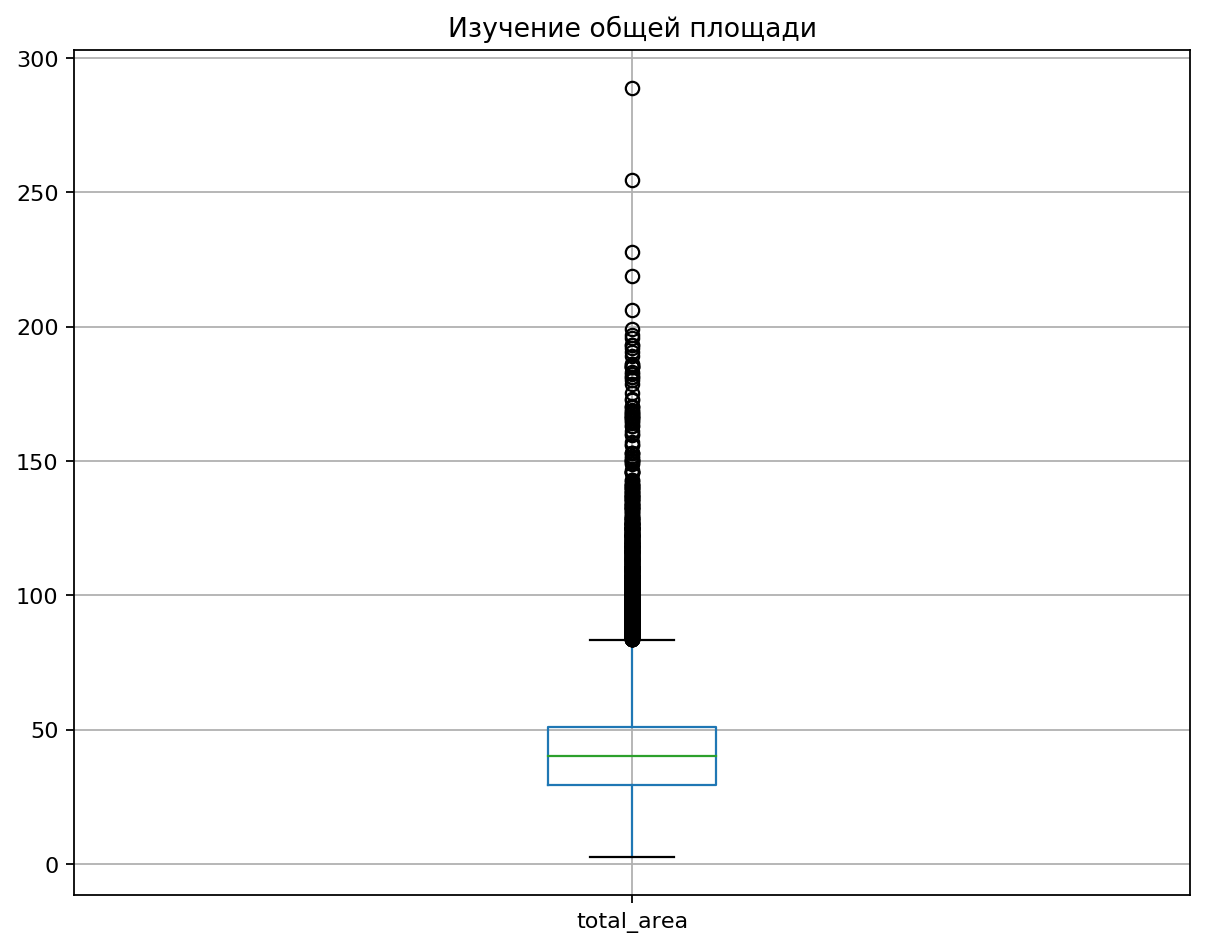

In [35]:
display_boxplot(wip_data, column='total_area', boxplot_title="Изучение общей площади", showfliers=True)

Разброс значений - до 500 метров! Возможно, пользователи, продающие квартиры, ошибались с размерностями или форма записи метража на сайте даёт пользователю ошибиться (к примеру, пользователь пишет 50 "точка" 0, а на сайте нужна запятая - вот и пишет 500).

##### Обработка выбросов для площади

Воспользуемся знаниями о межквартильном размахе, попытаясь устранить все неточности начальных данных.

In [36]:
lower_bord_area, higer_bord_area = quantile_calc(wip_data['total_area'])

Словарь перцентилей: {0.25: 29.3, 0.5: 40.1, 0.75: 51.0}
IQR - 21.70
Нижняя граница межквартильного размаха - -3.25
Верхняя граница межквартильного размаха - 83.55


Нижняя граница ниже нуля, с ней мы делать ничего не будем. С верхней - посмотрим, сколько значений пересекает верхнюю границу.

In [37]:
high_area_data = wip_data.query('total_area > @higer_bord_area')

high_area_data = high_area_data.sort_values(by='total_area', ascending=False)
display(high_area_data)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,squared_price,exposition_day,exposition_month,exposition_year,fl_cat,living_to_total,kitchen_to_total
6221,8,34000000.0,288.700000,2018-01-14,4,NaN,3,248.700000,3,False,...,3.0,122.0,179.0,72294.280247,14,1,2018,последний,0.528811,0.085052
2489,9,12500000.0,254.600000,2017-04-21,3,NaN,2,153.900000,2,False,...,3.0,198.0,102.0,49019.607843,21,4,2017,последний,0.603529,0.394902
19382,9,20786000.0,227.589173,2018-07-16,2,3.00,7,174.589173,4,False,...,0.0,NaN,5.0,190697.247706,16,7,2018,другое,1.601736,0.486239
7664,20,40000000.0,219.000000,2017-04-20,5,3.50,6,182.000000,4,False,...,1.0,399.0,81.0,126984.126984,20,4,2017,другое,0.577778,0.117460
11747,5,39773280.0,206.118497,2018-06-15,4,NaN,8,158.118497,5,False,...,1.0,895.0,96.0,292450.588235,15,6,2018,другое,1.162636,0.352941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10039,16,11490000.0,83.700000,2018-02-01,5,3.08,6,66.600000,3,False,...,0.0,NaN,NaN,94103.194103,1,2,2018,другое,0.545455,0.140049
18770,20,49000000.0,83.600000,2019-01-29,3,2.91,6,73.900000,6,False,...,3.0,258.0,NaN,392000.000000,29,1,2019,последний,0.591200,0.077600
18214,20,12990000.0,83.600000,2017-11-10,3,NaN,8,69.000000,8,False,...,3.0,553.0,120.0,110741.687980,10,11,2017,последний,0.588235,0.124467
7475,12,10900000.0,83.600000,2017-09-26,3,NaN,22,64.600000,1,False,...,1.0,525.0,208.0,85302.864298,26,9,2017,первый,0.505556,0.148693


Очень много значений, превышающих верхнюю границу межквартильного размаха. Мы не можем просто взять и выкинуть их.

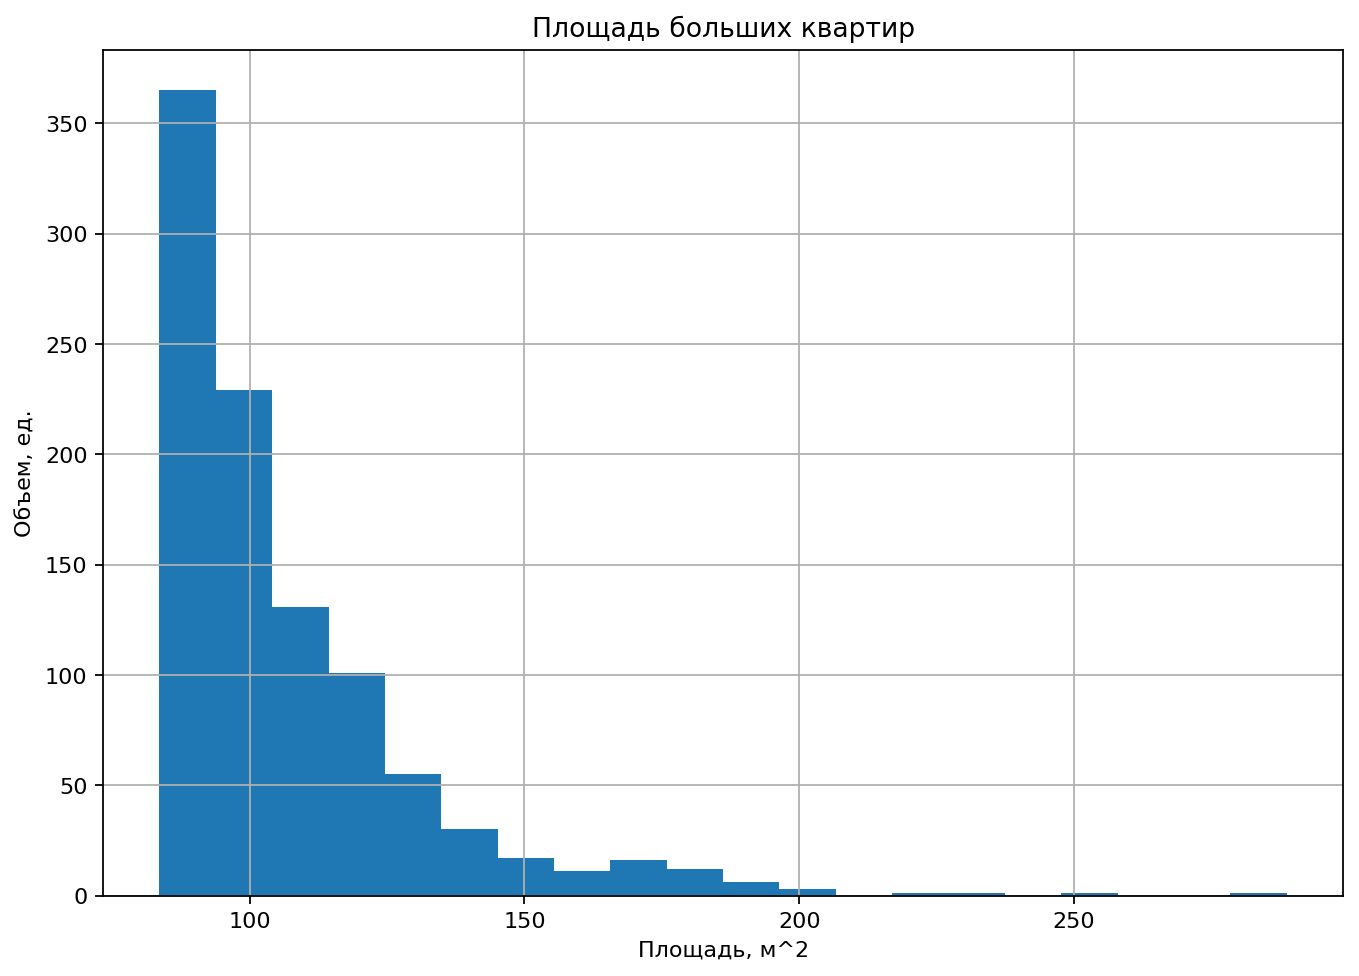

In [38]:
high_area_data = high_area_data.sort_values(by='total_area', ascending=False)
display_hist(high_area_data['total_area'], hist_title="Площадь больших квартир", hist_xlabel="Площадь, м^2", hist_bins=20)

При помощи графика видим, что больше 150 метров площадью квартир совсем мало. Посмотрим, насколько их мало.

In [39]:
high_area_data = wip_data.query('total_area > 150')
display(high_area_data)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,squared_price,exposition_day,exposition_month,exposition_year,fl_cat,living_to_total,kitchen_to_total
521,20,25717300.0,156.100000,2015-01-21,3,NaN,3,130.000000,1,False,...,3.0,278.0,1441.0,111765.754020,21,1,2015,первый,0.564972,0.113429
1187,10,25000000.0,166.000000,2015-08-07,5,3.50,6,131.000000,4,False,...,0.0,NaN,1117.0,124378.109453,7,8,2015,другое,0.651741,0.174129
1624,20,31500000.0,170.600000,2017-04-09,5,3.57,5,144.600000,4,False,...,2.0,486.0,NaN,132464.255677,9,4,2017,другое,0.608074,0.109336
2489,9,12500000.0,254.600000,2017-04-21,3,NaN,2,153.900000,2,False,...,3.0,198.0,102.0,49019.607843,21,4,2017,последний,0.603529,0.394902
2731,0,25000000.0,172.624241,2018-04-04,3,NaN,5,132.424241,5,False,...,0.0,NaN,NaN,168577.208361,4,4,2018,последний,0.892948,0.271072
2869,6,16000000.0,150.294737,2018-10-22,2,NaN,6,115.294737,4,False,...,1.0,859.0,115.0,219178.082192,22,10,2018,другое,1.579380,0.479452
3146,8,33000000.0,159.500000,2019-01-23,5,3.86,6,144.500000,3,False,...,0.0,NaN,47.0,142241.379310,23,1,2019,другое,0.622845,0.064655
3267,1,25092624.0,166.700000,2015-12-08,5,3.00,3,155.100000,1,False,...,2.0,471.0,660.0,94262.299023,8,12,2015,первый,0.582645,0.043576
3303,20,15750000.0,199.200000,2018-06-15,4,NaN,17,159.200000,17,False,...,1.0,703.0,264.0,73598.130841,15,6,2018,последний,0.743925,0.186916
3676,12,28789000.0,150.509444,2019-01-23,4,NaN,6,115.459444,6,False,...,0.0,NaN,NaN,65136.431513,23,1,2019,последний,0.261232,0.079302


Совсем небольшое количество. В таком случае, избавимся от этих объявлений.

In [40]:
wip_data = wip_data.query('total_area < 150')

#### Потолки

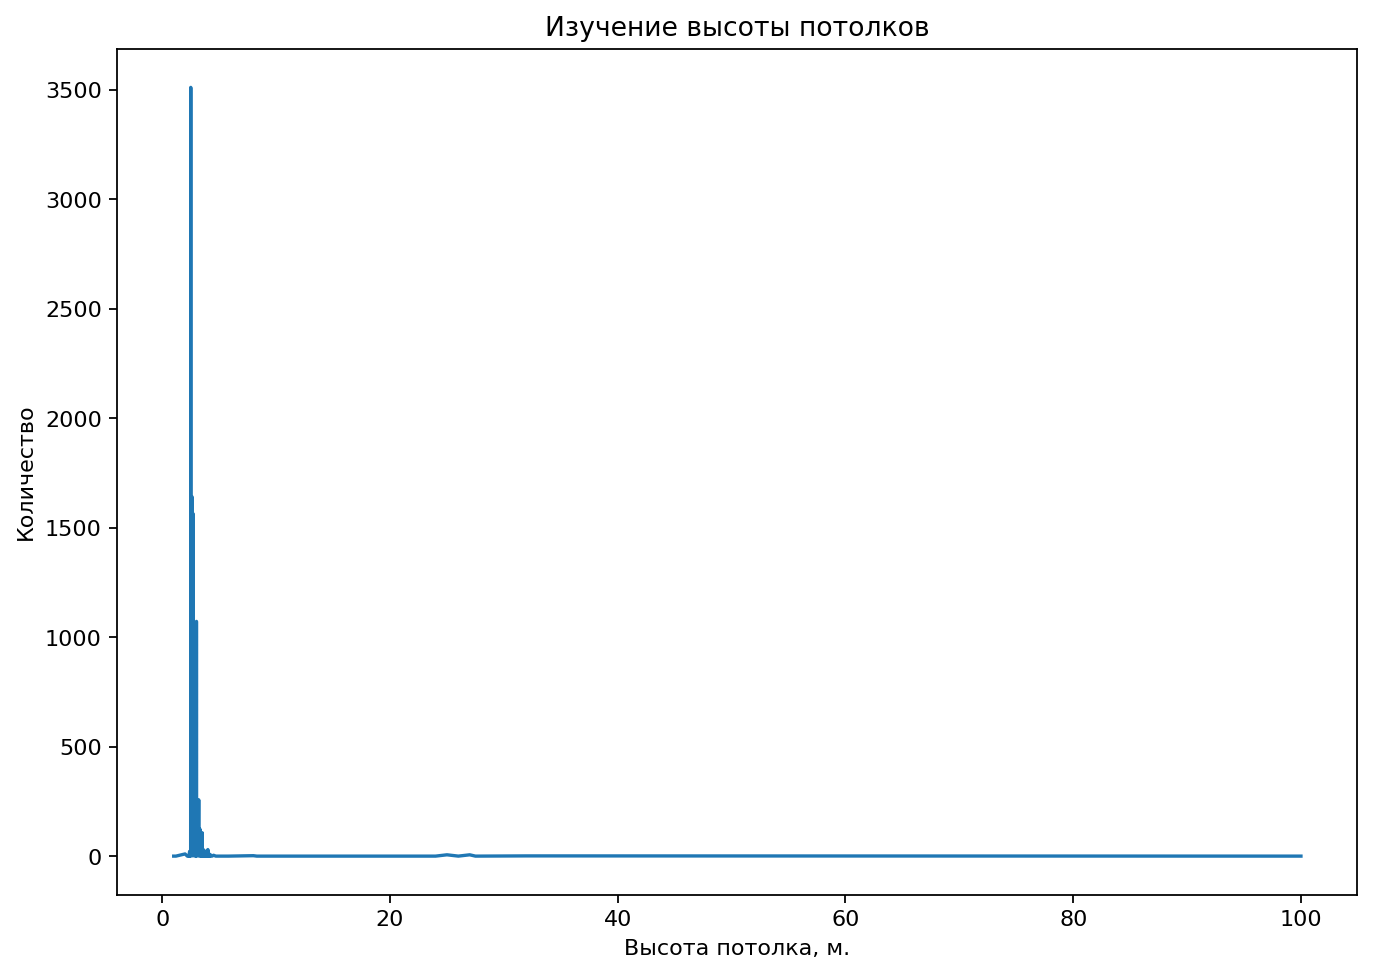

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,squared_price,exposition_day,exposition_month,exposition_year,fl_cat,living_to_total,kitchen_to_total
22590,16,6000000.0,42.400000,2018-10-31,2,1.00,12,32.400000,7,False,...,2.0,289.0,13.0,109090.909091,31,10,2018,другое,0.589091,0.181818
5712,5,1500000.0,32.700000,2017-08-14,2,1.20,2,27.500000,1,False,...,NaN,NaN,248.0,35046.728972,14,8,2017,первый,0.642523,0.121495
552,11,2999000.0,24.000000,2017-03-30,1,2.00,15,17.500000,6,False,...,1.0,949.0,270.0,89522.388060,30,3,2017,другое,0.522388,0.194030
5850,9,1650000.0,45.161367,2018-05-29,1,2.00,5,34.644380,5,False,...,NaN,NaN,100.0,46478.873239,29,5,2018,последний,0.975898,0.296253
19329,5,1700000.0,45.161367,2018-07-15,2,2.00,9,34.644380,8,False,...,NaN,NaN,45.0,42500.000000,15,7,2018,другое,0.866110,0.262925
2572,4,2400000.0,46.000000,2018-12-27,3,2.00,5,40.000000,4,False,...,NaN,NaN,NaN,38709.677419,27,12,2018,другое,0.645161,0.096774
20520,9,3600000.0,26.800000,2018-07-05,1,2.00,12,15.000000,9,False,...,NaN,NaN,62.0,94736.842105,5,7,2018,другое,0.394737,0.310526
4212,1,2120000.0,25.400000,2017-12-18,1,2.00,18,16.600000,9,False,...,NaN,NaN,36.0,59836.296924,18,12,2017,другое,0.468529,0.248377
22960,17,2300000.0,29.000000,2018-10-18,2,2.00,2,19.000000,1,False,...,NaN,NaN,NaN,42910.447761,18,10,2018,первый,0.354478,0.186567
16884,0,1500000.0,26.000000,2018-10-03,1,2.00,5,20.000000,5,False,...,NaN,NaN,6.0,45454.545455,3,10,2018,последний,0.606061,0.181818


In [41]:
'''plt.xlim(2,4)
plt.plot(wip_data.groupby('ceiling_height')['last_price'].count())
plt.show()'''

display_plot(df_plot= wip_data.groupby('ceiling_height')['last_price'].count(), plot_ylabel="Количество",
            plot_xlabel="Высота потолка, м.",plot_title="Изучение высоты потолков")

display(wip_data.sort_values(by='ceiling_height', ascending=True).head(15))

Два исключительных варианта с потолками меньше 2 метров. В двухметровые потолки также слабо верится, но их количество = 10 из выборки в 20 тысяч. Избавимся от них, чтобы такие слишком малые значения не портили статистику.


Другое дело - высокие потолки. График тянется вплоть до 30 метров. Посмотрим, что там с аппартаментами-гигантами. 

In [42]:
display(wip_data.sort_values(by='ceiling_height', ascending=False).head(30))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,squared_price,exposition_day,exposition_month,exposition_year,fl_cat,living_to_total,kitchen_to_total
22869,0,15000000.0,25.000000,2018-07-25,1,100.0,5,14.0,5,True,...,3.0,30.0,19.0,600000.000000,25,7,2018,последний,0.560000,0.440000
3148,14,2900000.0,61.000000,2018-11-12,3,32.0,3,53.0,2,False,...,NaN,NaN,NaN,38666.666667,12,11,2018,другое,0.706667,0.106667
22336,19,9999000.0,72.000000,2019-04-05,2,32.0,6,55.5,5,False,...,3.0,511.0,NaN,108214.285714,5,4,2019,другое,0.600649,0.178571
21377,19,4900000.0,48.700000,2017-04-18,1,27.5,24,37.7,19,False,...,0.0,NaN,61.0,116666.666667,18,4,2017,другое,0.897619,0.261905
17857,1,3900000.0,43.017803,2017-12-22,3,27.0,5,33.0,4,False,...,0.0,NaN,73.0,69642.857143,22,12,2017,другое,0.589286,0.178889
5246,0,2500000.0,39.000000,2017-10-13,2,27.0,5,30.0,3,False,...,NaN,NaN,540.0,46296.296296,13,10,2017,другое,0.555556,0.166667
4876,7,3000000.0,22.160687,2017-09-27,0,27.0,25,17.0,17,False,...,NaN,NaN,28.0,120000.000000,27,9,2017,другое,0.680000,0.206427
21824,20,2450000.0,46.600000,2019-02-12,2,27.0,2,38.0,2,False,...,NaN,NaN,NaN,55681.818182,12,2,2019,последний,0.863636,0.195455
22938,14,4000000.0,82.000000,2018-03-15,4,27.0,2,73.0,2,True,...,NaN,NaN,27.0,40816.326531,15,3,2018,последний,0.744898,0.091837
10773,8,3800000.0,38.200000,2017-10-13,2,27.0,10,30.1,3,False,...,NaN,NaN,71.0,65517.241379,13,10,2017,другое,0.518966,0.139655


Стоимости тоимости кварти в случае с потолками выше 6 метров вызывают много сомнений. К тому же их всего 25 штук, поэтому избавимся от них и посмотрим на обновленный график.

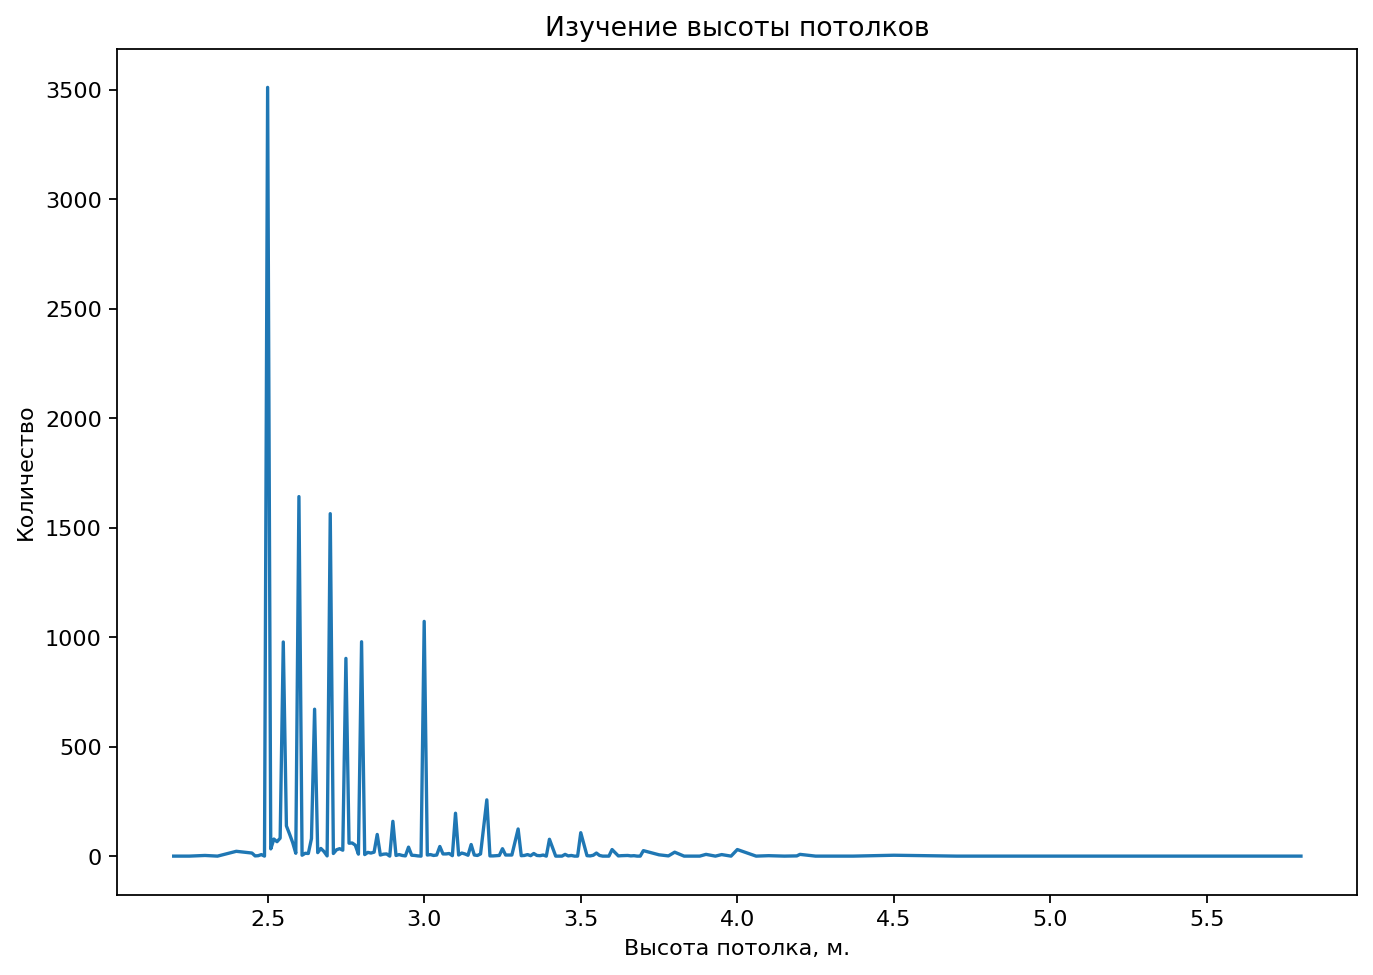

In [43]:
wip_data = wip_data.query('ceiling_height > 2.00 & ceiling_height <= 6.00')

display_plot(df_plot= wip_data.groupby('ceiling_height')['last_price'].count(), plot_ylabel="Количество",
            plot_xlabel="Высота потолка, м.",plot_title="Изучение высоты потолков")

#### Вывод

В рамках данного пункта были изучены основные факторы для всех объявлений. 

Мы обнаружили следующие недостатки в полученных данных:

1) Пользователи могут указывать необычайно большие потолки. Ошибка встречается редко, но можно подумать - можем ли мы помочь им не совершать такую ошибку?

2) Пользователи могут ошибочно указать площадь в необычнайно большом диапазоне значений.

Почему эти ошибки важны? Потому что люди, ищущие по объявлениям, могут, к примеру, выбирать диапазон по площади, и некоторым объявлениям из-за верхней границы этого диапазона будет не суждено быть показанными.

В остальном, мы получили типовые значения параметров продаваемых квартир по площади, кол-ву комнат, высоте потолков, стоимости: у нас есть представление о типовых значениях, а также о минимальных и даже аномальных. Эти данные можно будет обновлять и сверять, анализируя изменения на рынке. 

Уже сейчас можно сделать, к примеру, разделение цены по годам и увидеть динамику от 2017 года по наше время (к примеру). Но это мы уже сделаем чуть ниже.


###  Время продажи квартиры

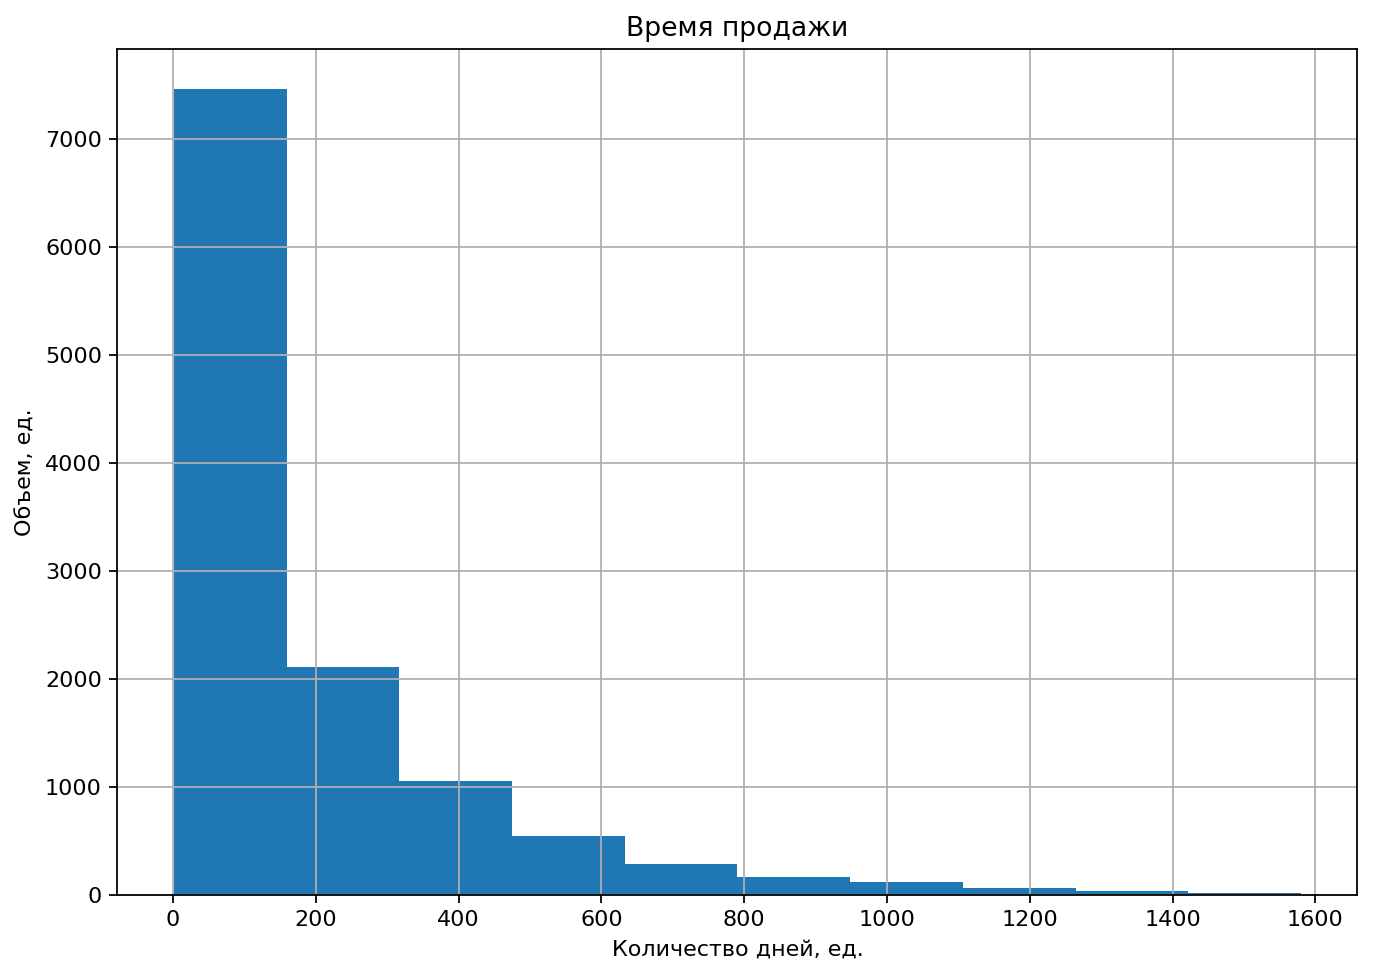

count    11829.000000
mean       188.363767
std        226.610189
min          1.000000
25%         45.000000
50%        102.000000
75%        244.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [44]:
display_hist(wip_data['days_exposition'], hist_title="Время продажи", hist_xlabel="Количество дней, ед.")

wip_data['days_exposition'].describe()

In [45]:
print('Средняя - {:.0f} дней'.format(wip_data['days_exposition'].mean()))
print('Медиана - {:.0f} дней'.format(wip_data['days_exposition'].median()))

print('Рассмотрим перцентили')

wip_data['days_exposition'].quantile([.15, .25, .5, .75])

Средняя - 188 дней
Медиана - 102 дней
Рассмотрим перцентили


0.15     26.0
0.25     45.0
0.50    102.0
0.75    244.0
Name: days_exposition, dtype: float64

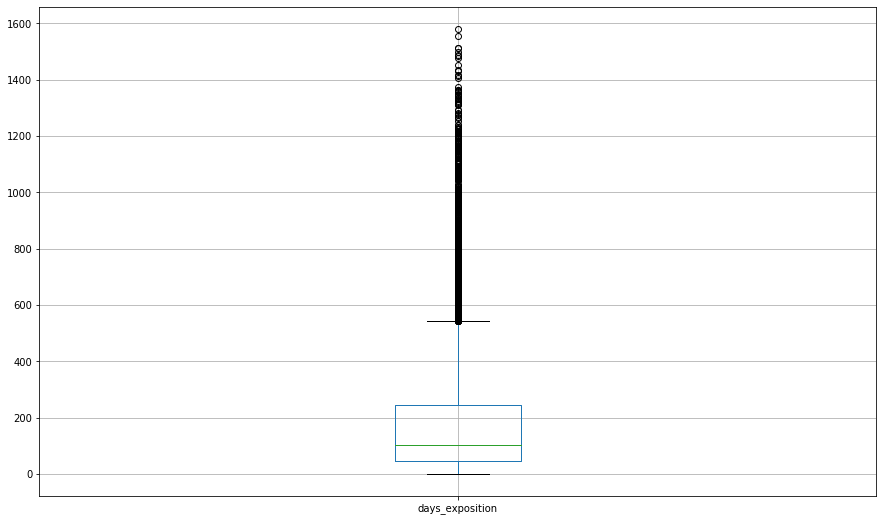

In [46]:
wip_data.boxplot(column = 'days_exposition', figsize=(15,9))

Разница между средним и медианой довольно большая, поэтому лучше ориентироваться на значение медианы, так как оно отражает пятидесятый квартиль по частоте.

При помощи boxplot узнаём границы наших "усов". Нижняя граница равна нулю, поэтому точно ответить на вопрос "а что можно считать быстрой продажей квартиры" мы не сможем. То же самое с вопросом про медленную продажу.

Вообще, в данном случае мне кажется, что надо брать 15 и 75 перцентили от общих значений. Значение 15 перцентиля равно 25 дням, что составляет примерно месяц. Продать квартиру за месяц - выглядит как действительно очень быстрый срок.

По 75 перцентилю получили 238 дней, что составляет 7,6 месяцев. С учетом того, что медиана у нас - примерно 4 месяца, то срок в 7,6 месяцев звучит как действительно долгий.

#### Выводы

В рамках данного пункта мы рассмотрели основные факторы, которыми можно описать квартиру - площадь, количество комнат, удаленность от центра, этажность. Были сделаны основные выводы по каждому фактору, построены соответствующие графики.

### Какие факторы больше всего влияют на стоимость квартиры?

#### Общая корреляция

Попробуем рассмотреть, коррелируется ли стоимость квартиры от следующих параметров: количество квадратных метров, числа комнат, этажа, удаленности от центра.

In [47]:
print('Корреляция по Пирсону:')
print('Корреляция с числом квадратных метров - {}'.format(wip_data['last_price'].corr(wip_data['total_area'])))
print('Корреляция с количеством комнат - {}'.format(wip_data['last_price'].corr(wip_data['rooms'])))
print('Корреляция с удаленностью от центра - {}'.format(wip_data['last_price'].corr(wip_data['cityCenters_nearest'])))

Корреляция по Пирсону:
Корреляция с числом квадратных метров - 0.7087711204918373
Корреляция с количеством комнат - 0.4610768814413726
Корреляция с удаленностью от центра - -0.3255759755818924


Корреляция по Пирсону дала неоднозначные результаты:прослеживается зависимость между площадью и стоимостью квартиры. 

Другие же факторы совсем не указывают на изменение в цене. 
Естественно, больше количество комнат отразится на цене. Но также можно предположить, что чем больше квартира занимает по площади, тем больше комнат в ней. Попробуем пока что воспользоваться простым вариантом.


##### Графики корреляции значений

    Построим граффики типа scatter для отслеживания корреляции значений.

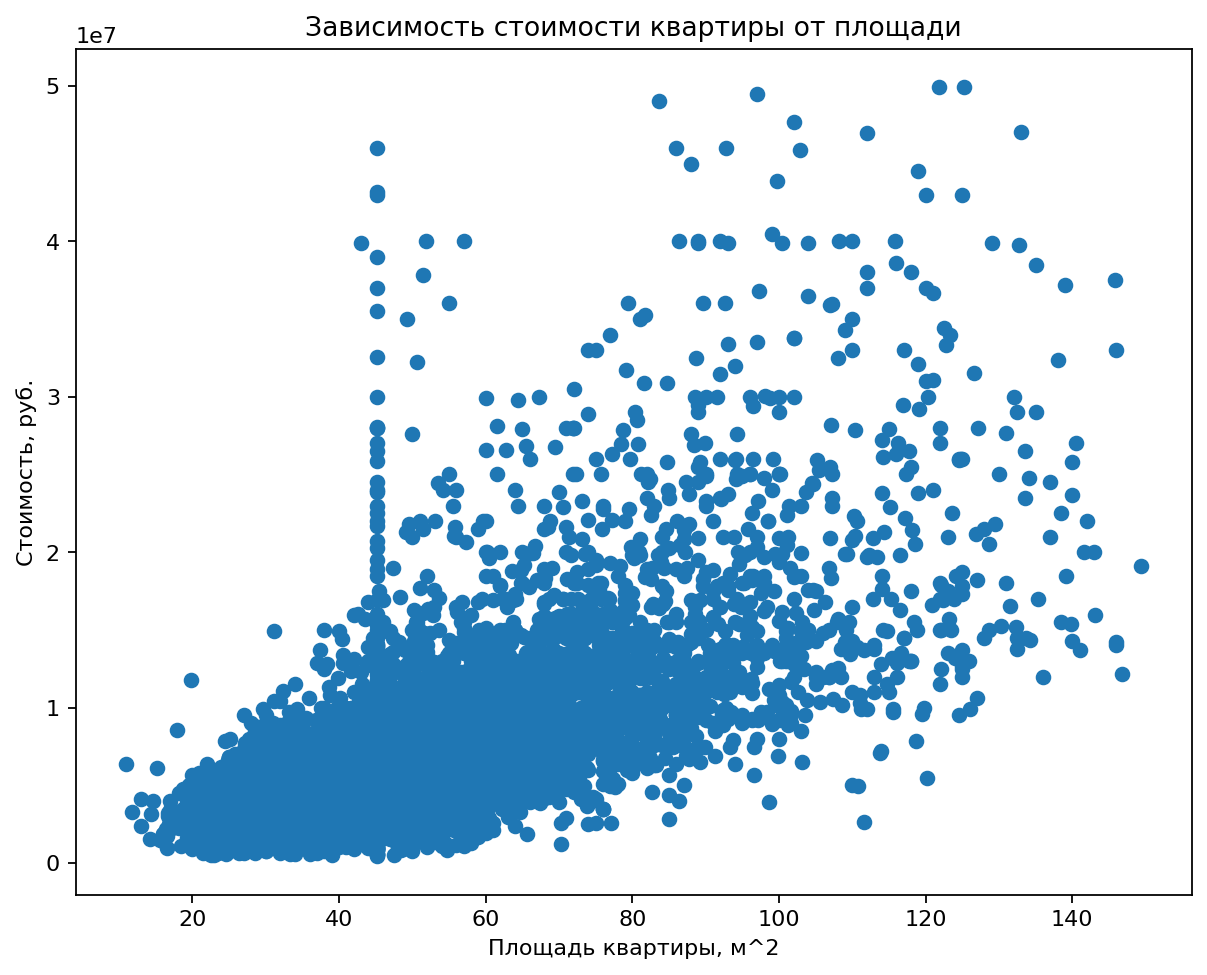

In [48]:
display_scatter(y=wip_data['last_price'], x=wip_data['total_area'], s_title="Зависимость стоимости квартиры от площади",
            s_ylabel="Стоимость, руб.", s_xlabel="Площадь квартиры, м^2")

С увеличением площади видим плавное увеличение минимальной стоимости. При этом обновляется максимальное значение стоимости квартиры.

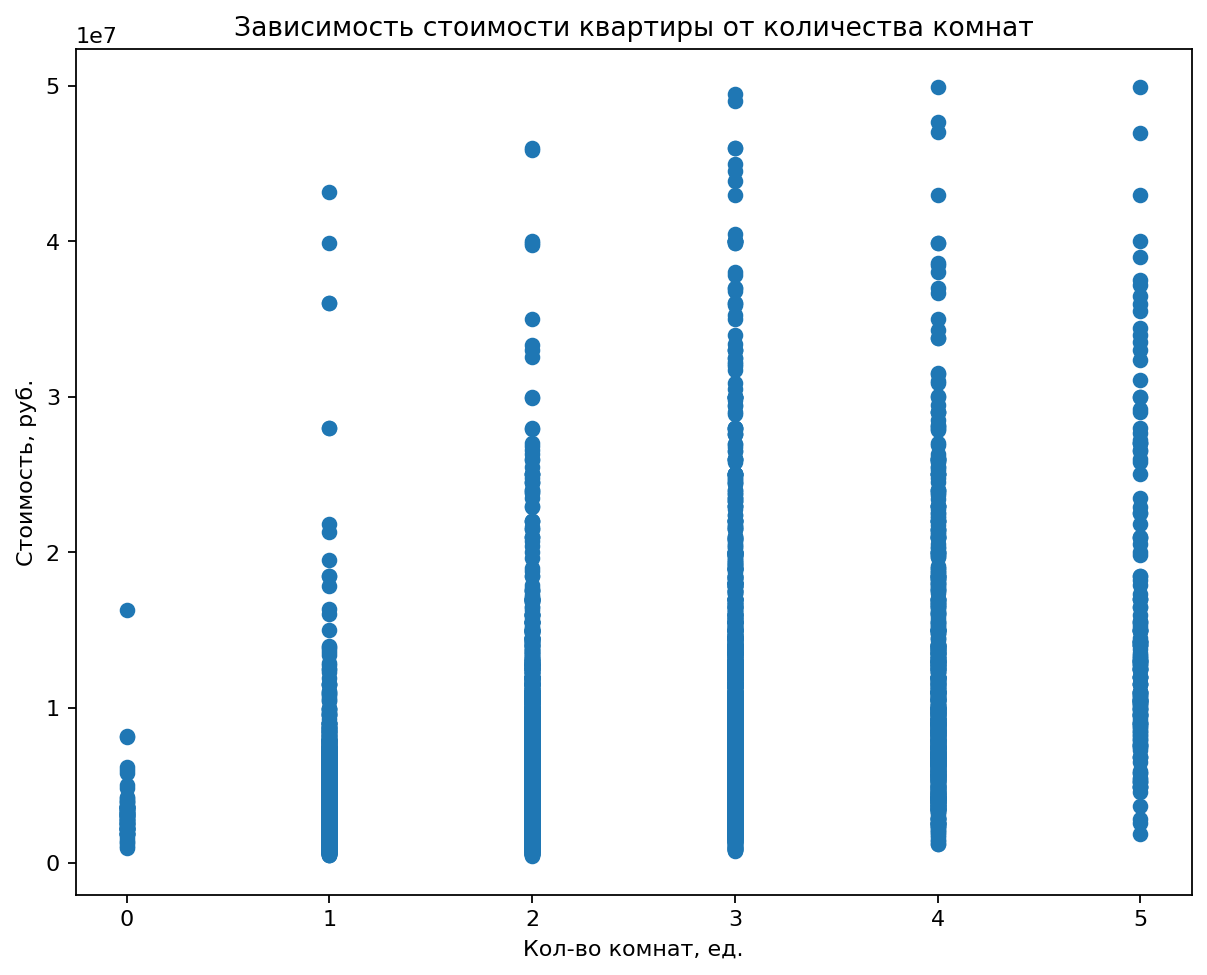

In [49]:
display_scatter(y=wip_data['last_price'], x=wip_data['rooms'], s_title="Зависимость стоимости квартиры от количества комнат",
            s_ylabel="Стоимость, руб.", s_xlabel="Кол-во комнат, ед.")

Scatter plot цена/комнаты не инфорамтивен. Вместо него вспомним о boxplot, который был использован ранее.

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


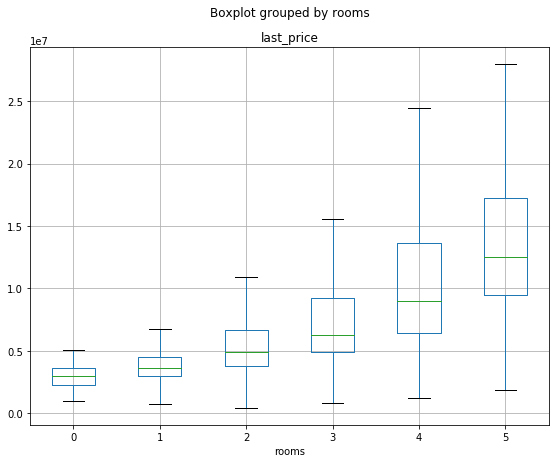

In [50]:
wip_data.boxplot('last_price', by='rooms', figsize=(9,7), showfliers=False)

Видим рост и цены, и разброс по ценам.

In [51]:
print('Корреляция количества комнат и площади квартиры - {}'.format(wip_data['total_area'].corr(wip_data['rooms'])))

Корреляция количества комнат и площади квартиры - 0.7855037409447054


Чем больше комнат - тем больше площадь. Поэтому также говорим о том, что количество комнат влияет на цену, но только из-за того, что увеличение количества комнат ведёт к естественному увеличению общей площади квартиры.

Посмотрим поближе на корреляцию цены и площадии: для этого возьмём только двухкомнатные квартиры, расположенные в 50 км. от центра. 

In [52]:
figure_out = wip_data.query('(rooms == 2) & (cityCenters_nearest < 50000)')

print('Корреляция цены с числом квадратных метров для двухкомнатных квартир \
      -{}'.format(figure_out['last_price'].corr(figure_out['total_area'])))

Корреляция цены с числом квадратных метров для двухкомнатных квартир       -0.6787277568059785


Коэффициент корреляции Пирсона сильная обратная корреляция. 

#### Этажность

In [53]:
display(wip_data.pivot_table(index='fl_cat', values='last_price', aggfunc=('median', 'mean', 'count')))

,count,mean,median
fl_cat,,,
другое,10379,6.364897e+06,5000000.0
первый,1794,4.705382e+06,4000000.0
последний,2026,5.960115e+06,4500000.0


Поиск зависимости между номером этажа и ценой нецелесообразен, поэтому данный пункт рассмотрим по трём различным категориям.

По этажности видна следующая тенденция - стоимость квартиры, находящейся на первом этаже, заметно ниже стоимостей квартир, находящихся на других этажах.

Это может быть связано с тем, что на первом этаже всё немного сложнее с безопасностью и окнами. Вор может проникнуть в квартиру через окно, окна на первом этаже хорошо просматриваются с улицы, а также на них необходимо ставить решётку. Это может негативно повлиять на настроение жильцов. 

Между последним этажом и любым другим также есть разница, но она не настолько велика. Скорее всего, последний этаж не так привлекателен, как любой другой, из-за проблем с подъемом, а также близостью к крыше.

Гипотеза: первый этаж - это удаленная от центра одноэтажка. Посмотрим на количество одноэтажек.

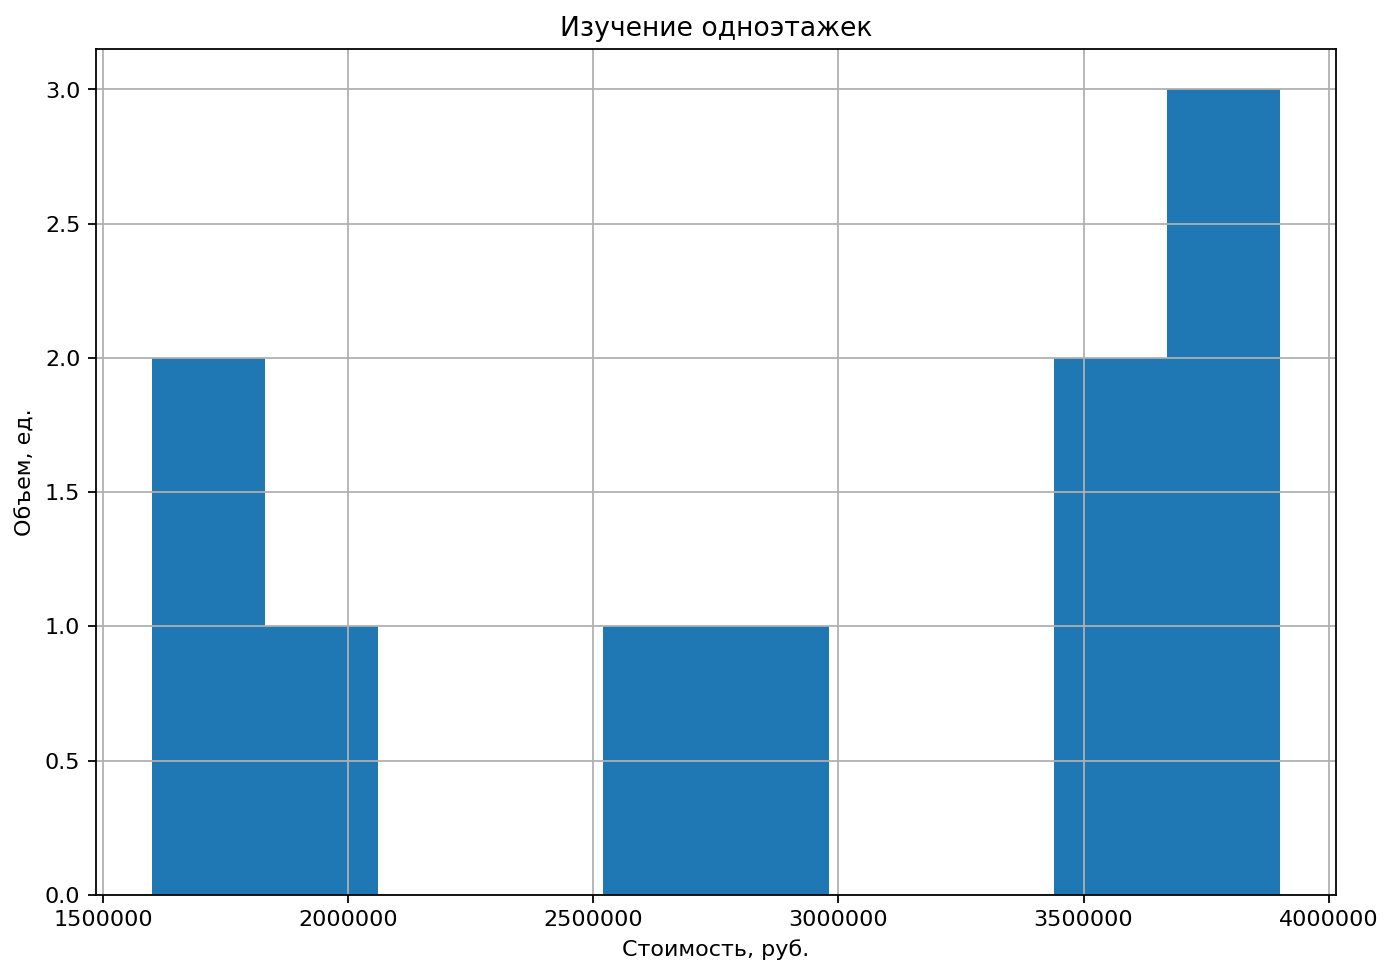

10

In [54]:
figure_out = wip_data.query('(floors_total == 1)')
display_hist(figure_out['last_price'], hist_title="Изучение одноэтажек", hist_xlabel="Стоимость, руб.")

figure_out['last_price'].count()

Меньше 50 одноэтажек, поэтому дальше смотреть на гипотезу бессмысленно.

#### Удаленность квартиры от центра

Теперь попробуем решить задачу с удаленностью квартиры от центра. Логично предположить, что чем ближе квартира к центру города, тем дороже её стоимость. Однако коэффициент корреляции Пирсона не дал нам такого эффекта. Посмотрим поближе на данные.

In [55]:
wip_data['cityCenters_nearest'].describe()
center_quantile = wip_data['cityCenters_nearest'].quantile([0.25 , 0.50 , 0.75])
center_quantile.to_dict()


def category_city(row):
    if row['cityCenters_nearest'] < center_quantile[0.25]:
        return 'Близко'
    if row['cityCenters_nearest'] >= center_quantile[0.25] and row['cityCenters_nearest'] < center_quantile[0.5]:
        return 'Средне'
    if row['cityCenters_nearest'] >= center_quantile[0.5] and row['cityCenters_nearest'] < center_quantile[0.75]:
        return 'Далеко'
    if row['cityCenters_nearest'] > center_quantile[0.75]:
        return 'Очень далеко'
    if row['cityCenters_nearest'] == None:
        return 'Беда'
    
wip_data['city_cat'] = wip_data.apply(category_city, axis=1)

display(wip_data.pivot_table(index='city_cat', values='last_price', aggfunc=('median', 'mean', 'count')))


,count,mean,median
city_cat,,,
Близко,2819,1.050222e+07,8400000.0
Далеко,2824,5.810400e+06,5000000.0
Очень далеко,2819,4.980536e+06,4310000.0
Средне,2815,6.170572e+06,5100000.0


Квартиры, находящиеся близко к центру, в среднем стоят дороже остальных на порядок. По медиане - аналогично.

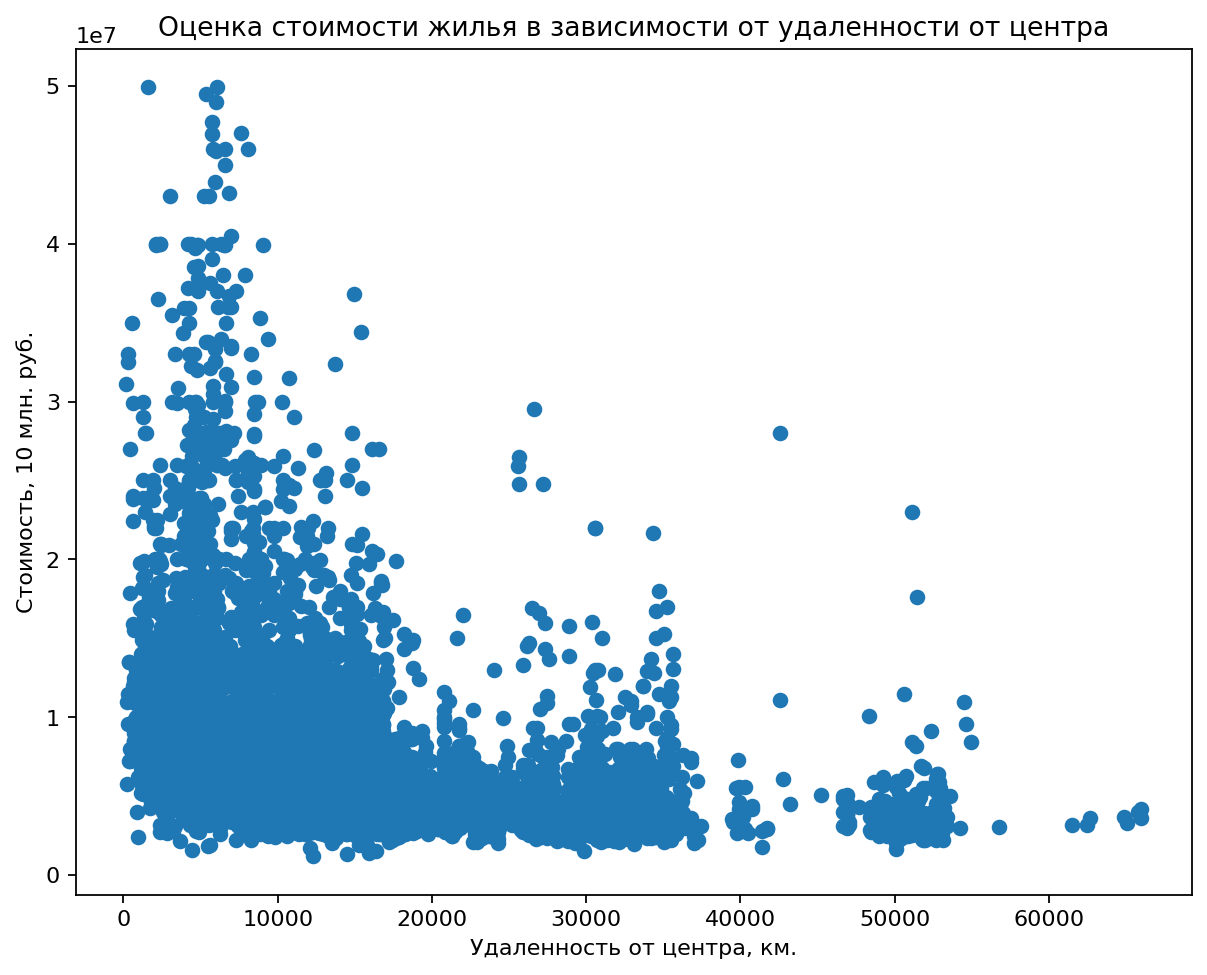

In [56]:
display_scatter(x= wip_data['cityCenters_nearest'], y= wip_data['last_price'], s_title='Оценка стоимости жилья в зависимости от удаленности от центра', 
                s_xlabel='Удаленность от центра, км.', s_ylabel='Стоимость, 10 млн. руб.')

На графике видно, как минимальная цена на квартиру увеличивается в зависимости от близости к центру. 

Теперь выведем топ 10 населённых пунктов с наибольшим числом объявлений и посмотрим на динамику.

In [59]:
loc_pivot = MMC_pivot(wip_data, 'locality_name', 'squared_price', func_return=1)
loc_pivot.columns = ['mean', 'median', 'count']

loc_pivot = loc_pivot.sort_values(by='count', ascending=False)

top_loc = loc_pivot.head(10)

display(top_loc)

,mean,median,count
,squared_price,squared_price,squared_price
locality_name,,,
бокситогорск,19098.143236,19098.143236,2
волосово,40208.886370,39812.646370,19
волхов,35272.859812,35454.545455,57
всеволожск,67434.629936,65789.473684,271
выборг,59220.779125,59838.709677,96
...,...,...,...
сосновый бор,76655.727210,74823.943662,50
сясьстрой,34855.962661,35133.239832,10


,mean,median,count
locality_name,,,
санкт-петербург,113020.078141,105430.377310,9828
всеволожск,67434.629936,65789.473684,271
пушкин,103965.889009,100000.000000,232
посёлок шушары,79286.491658,77661.027977,216
колпино,75938.525561,74725.274725,203
посёлок мурино,87369.004392,86157.557209,198
гатчина,70024.959358,68979.744936,148
петергоф,85554.144673,82142.857143,145
посёлок парголово,90901.351145,91040.462428,137


Более половины объявлений по продаже квартиры приходится на Санкт-Петербург. И стоимость квадратного метра лидирует в Петербурге. 

Теперь посмотрим, где у нас самые дорогие, а где самые дешевые квартиры.

In [60]:
minmax_pivot = wip_data.pivot_table(index='locality_name', values=['last_price', 'squared_price'], aggfunc=['max', 'min'])

minmax_pivot = minmax_pivot.sort_values(by=('max', 'last_price'), ascending=False)

display(minmax_pivot.head(10))
display(minmax_pivot.tail(10))

max                        min              
                         last_price  squared_price  last_price squared_price
locality_name                                                               
санкт-петербург          49900000.0  848484.848485   1200000.0  16842.105263
пушкин                   29500000.0  256521.739130   2200000.0  59836.065574
посёлок репино           28000000.0  175000.000000   4500000.0  68870.043559
зеленогорск              23000000.0  323943.661972   2950000.0  53303.720155
петергоф                 22000000.0  225971.731449   2100000.0  57692.307692
сестрорецк               21700000.0  182688.172043   3000000.0  53333.333333
выборг                   19990000.0  107473.118280    690000.0  24075.366364
кронштадт                17630000.0  111470.588235   2290000.0  52033.492823
гатчина                  13900000.0  146315.789474   1050000.0  18103.448276
посёлок александровская  13700000.0   76966.292135  13700000.0  76966.292135

max                \
                                           last_price squared_price   
locality_name                                                         
поселок серебрянский                         900000.0  20454.545455   
поселок почап                                850000.0  16037.735849   
посёлок при железнодорожной станции вещево   850000.0  28716.216216   
поселок городского типа ефимовский           850000.0  12686.567164   
деревня ялгино                               777000.0  17659.090909   
поселок городского типа кондратьево          750000.0  25000.000000   
деревня коркино                              700000.0  22950.819672   
деревня фалилеево                            600000.0  13303.769401   
поселок совхозный                            565000.0  12555.555556   
деревня вахнова кара                         450000.0  11688.311688   

                                                  min                
                                           last_price squared_price  
locality_name                                                        
поселок серебрянский                         585000.0  13058.035714  
поселок почап                                850000.0  16037.735849  
посёлок при железнодорожной станции вещево   850000.0  28716.216216  
поселок городского типа ефимовский           850000.0  12686.567164  
деревня ялгино                               777000.0  17659.090909  
поселок городского типа кондратьево          750000.0  25000.000000  
деревня коркино                              700000.0  22950.819672  
деревня фалилеево                            600000.0  13303.769401  
поселок совхозный                            565000.0  12555.555556  
деревня вахнова кара                         450000.0  11688.311688

Вполне ожидаемо, что в топ-10 самых дешевых локаций войдут одни деревни и поселки городского типа, а в топ-10 по самым дорогим - такие места, как СПб, Петергоф и Пушкин. 

#### День, месяц и год продажи квартиры

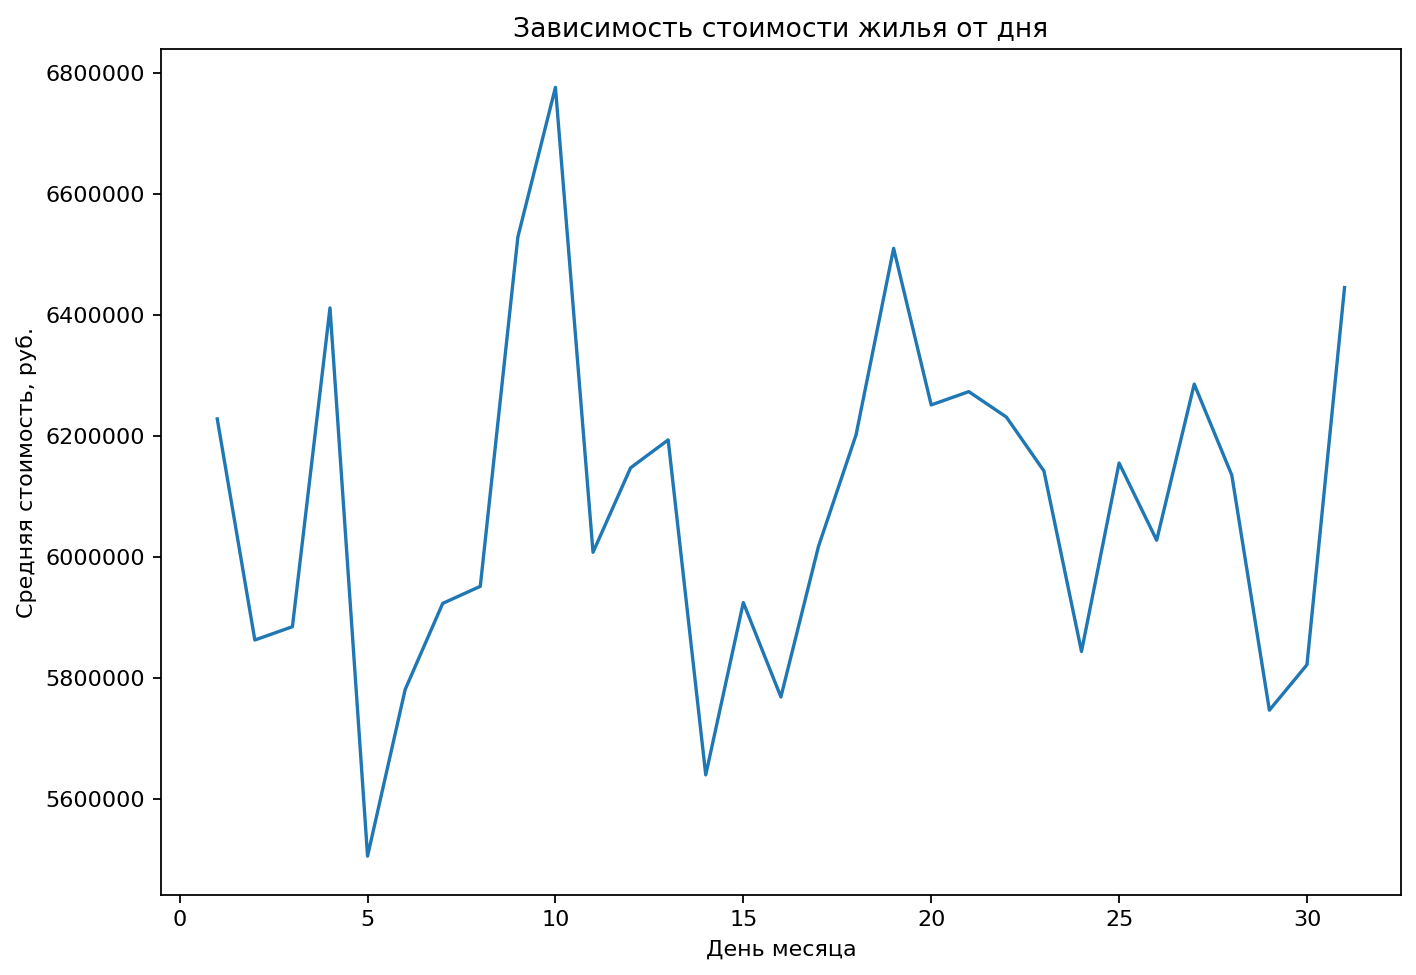

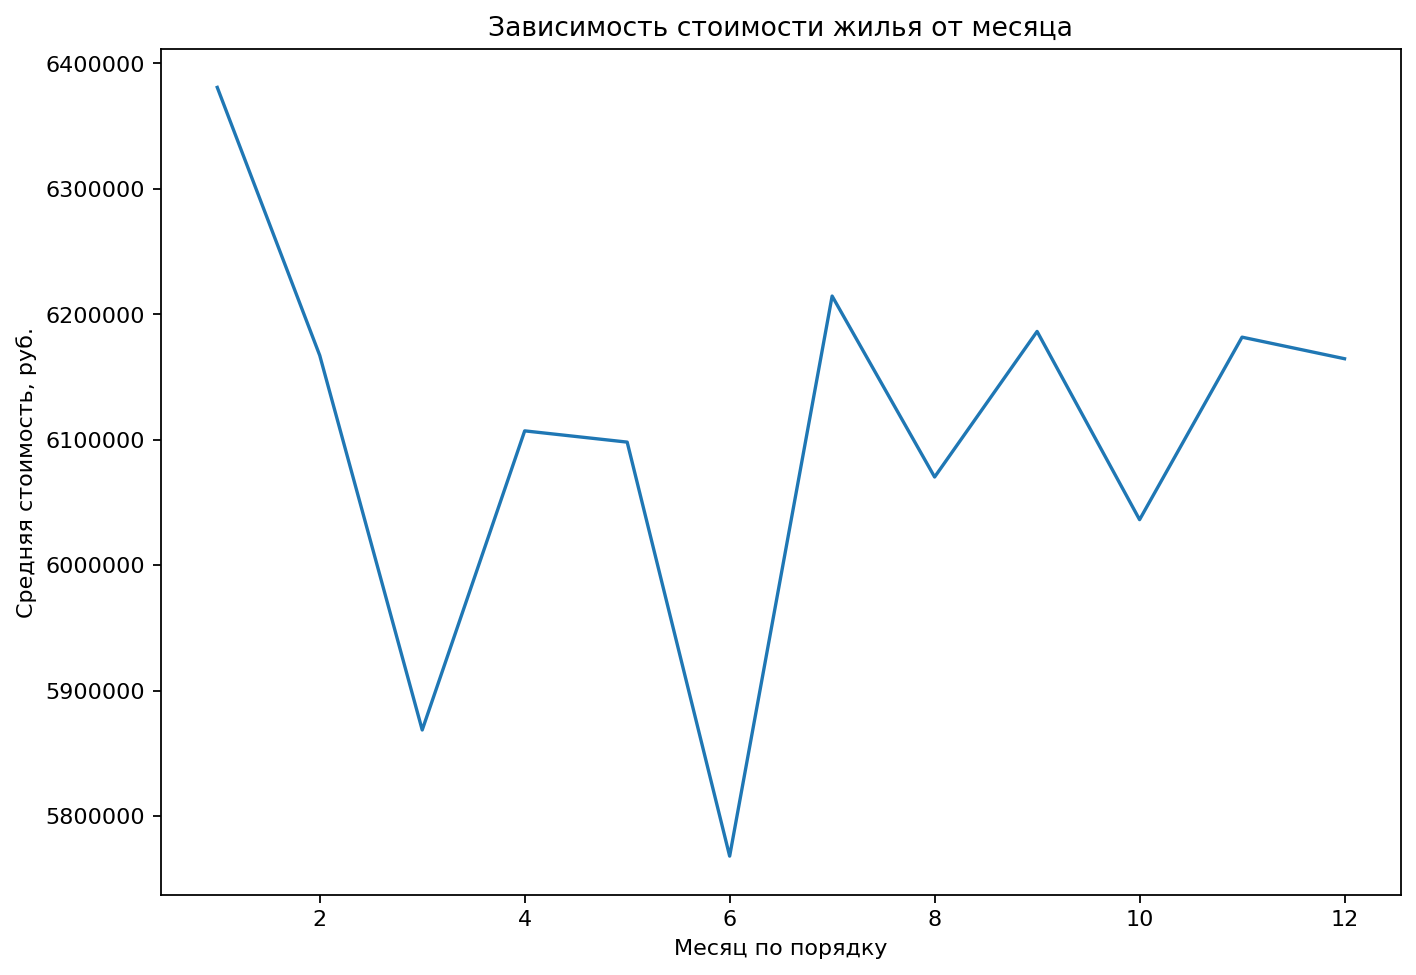

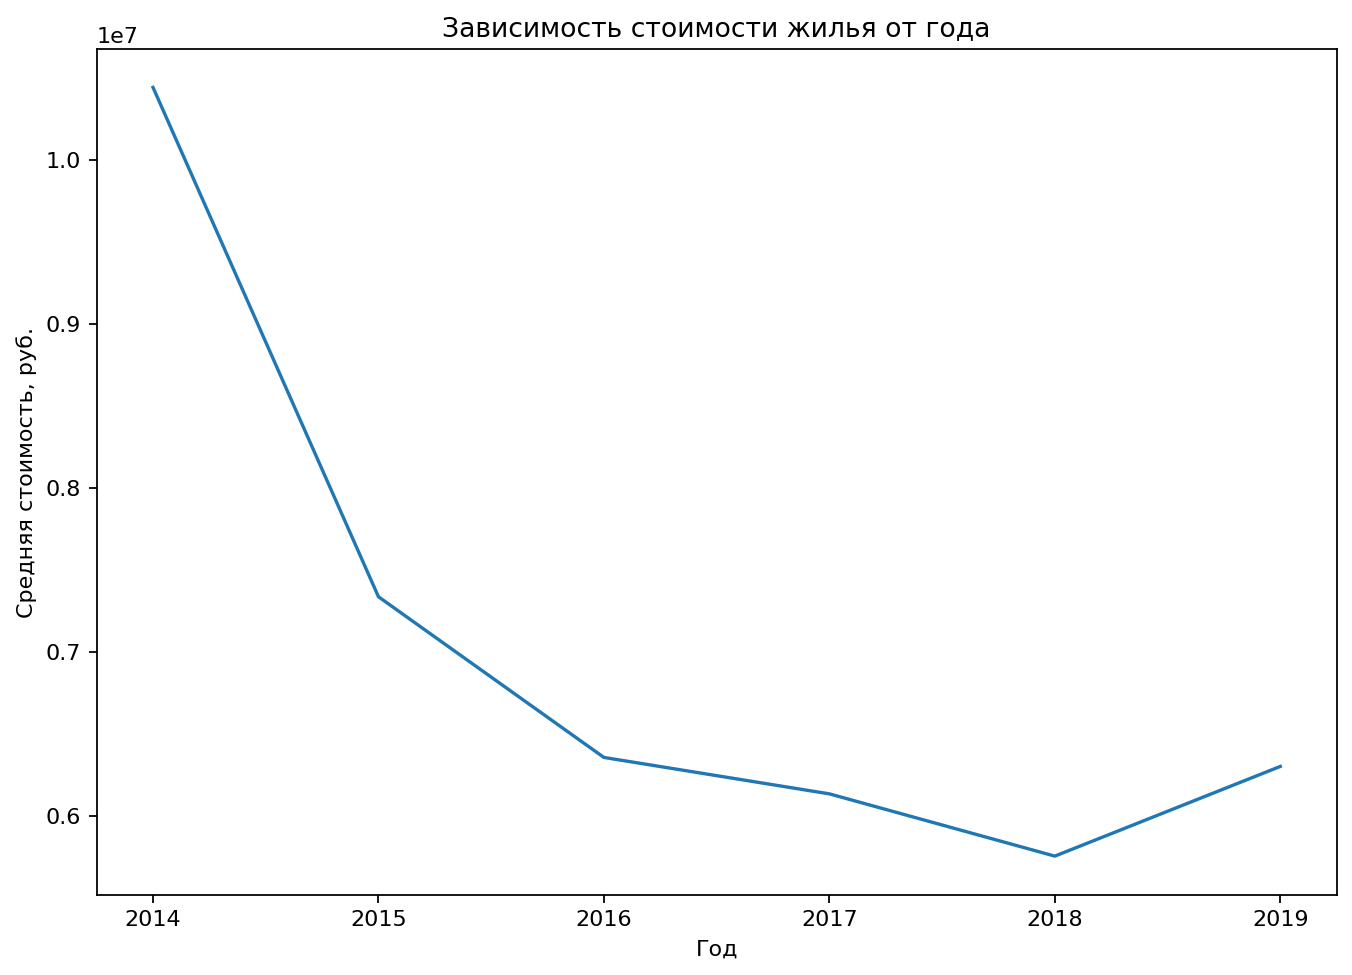

In [61]:
def dmy_analysis(dataframe):
    day_pivot = MMC_pivot(dataframe, 'exposition_day', 'last_price', func_return=1, show = 0)
    month_pivot = MMC_pivot(dataframe, 'exposition_month', 'last_price', func_return=1, show = 0)
    year_pivot = MMC_pivot(dataframe, 'exposition_year', 'last_price', func_return=1, show = 0)

    display_plot(day_pivot['mean', 'last_price'], plot_xlabel = "День месяца", plot_ylabel ="Средняя стоимость, руб.",
                plot_title="Зависимость стоимости жилья от дня")
    display_plot(month_pivot['mean', 'last_price'], plot_xlabel = "Месяц по порядку", plot_ylabel ="Средняя стоимость, руб.",
                plot_title="Зависимость стоимости жилья от месяца")
    display_plot(year_pivot['mean', 'last_price'], plot_xlabel = "Год", plot_ylabel ="Средняя стоимость, руб.",
                plot_title="Зависимость стоимости жилья от года")


dmy_analysis(wip_data)

Какой-либо зависимости стоимости продажи квартиры от дня нет. При этом наблюдается пик на 10-ом дне. Что в нем особенного? 

Из анализа размещения объявлений по месяцам видим, что стоимость резко падает после зимы - до марта квартиры падают в цене. Минимальная стоимость за квартиру наблюдается в июне. 

Ежегодная динамика показывает, что средняя стоимость квартир падает год к году; только 2019 год пытается обратить эту отрицательную динамику. 

#### Выводы по задаче.

В ходе изучения различных видов корреляции были получены следующие результаты:

1) Фактор, наиболее влияющий на стоимость квартиры - общая площадь жилья. Другие факторы (этажность, расстояние от центра, а также количество комнат) оказывают меньшее влияние. 

2) Продавать квартиру лучше всего в декабре, так как в этот месяц стоимость реализуемых квартир - наибольшая. 

3) В среднем достаточно 200 дней для того, чтобы реализовать квартиру. Если за этот период времени она не была реализована - возможно, цена, по которой она была выставлена, слишком высока.

### Изучение предложений квартир в Санкт-Петербурге

#### Выделяем квартиры в Санкт-Петербурге

In [62]:
spb_data = wip_data.loc[(wip_data['locality_name'] == 'санкт-петербург') & (wip_data['cityCenters_nearest'].isna() == False)]

Сделали выборку значений только по Санкт-Петербургу. При этом убрали несколько строк, где не было значения cityCenters_nearest, ведь.

#### Получение километража 

In [63]:
def set_kilo(num):
    if num%1000 < 500:
        return num//1000
    return num//1000 + 1

spb_data['kilometers'] = spb_data['cityCenters_nearest'].apply(set_kilo)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Написали небольшую функцию, которая делит и округляет расстояние от центра.

#### Расчет средней цены для километра, построение графика

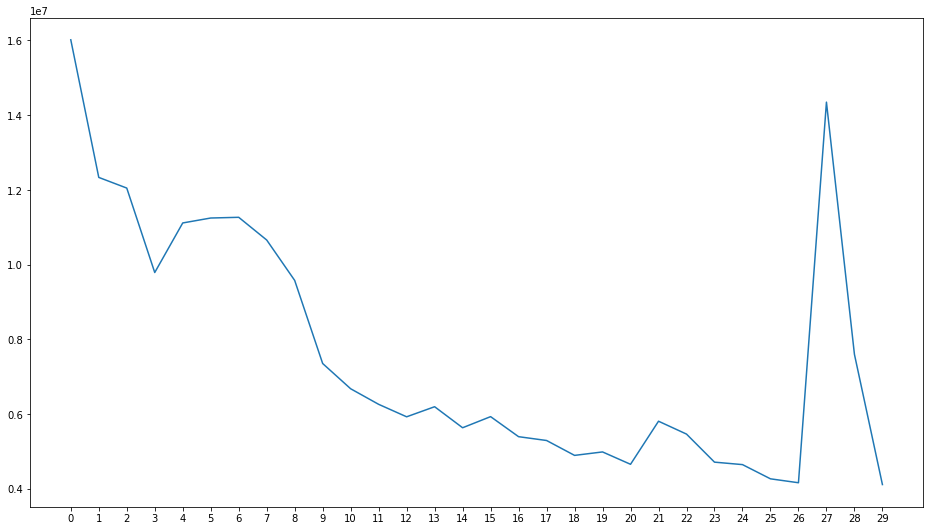

In [64]:
kilo_pivot = spb_data.pivot_table(index='kilometers', values='last_price', aggfunc='mean')

# здесь был добавлен параметр xticks, я с ним нигде не работал, поэтому не автоматизировал
plt.figure(figsize=(16,9))
plt.xticks(range(int(spb_data['kilometers'].max())+1))
plt.plot(kilo_pivot['last_price'])
plt.show()



#### Вывод


Цена резко падает на третьем километре, а это значит, что центром является область в виде окружности радиусом в 3 километра.

### Изучение сегмента квартир в центре

На прошлом этапе мы отметили, что жильё находится в центре тогда, когда расстояние от этого жилья до центра составляет менее 3 километров. Теперь изучим влияние различных факторов на квартиры, расположенные в центре и попробуем сравнить их с тем, что мы получили ранее.

In [65]:
central = wip_data.query('cityCenters_nearest <= 3000')

central.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 396 entries, 179 to 23648
Data columns (total 30 columns):
total_images            396 non-null int64
last_price              396 non-null float64
total_area              396 non-null float64
first_day_exposition    396 non-null datetime64[ns]
rooms                   396 non-null int64
ceiling_height          396 non-null float64
floors_total            396 non-null int64
living_area             396 non-null float64
floor                   396 non-null int64
is_apartment            396 non-null bool
studio                  396 non-null bool
open_plan               396 non-null bool
kitchen_area            396 non-null float64
balcony                 396 non-null int64
locality_name           394 non-null object
airports_nearest        396 non-null float64
cityCenters_nearest     396 non-null float64
parks_around3000        396 non-null float64
parks_nearest           316 non-null float64
ponds_around3000        396 non-null float64
pond

#### Площадь

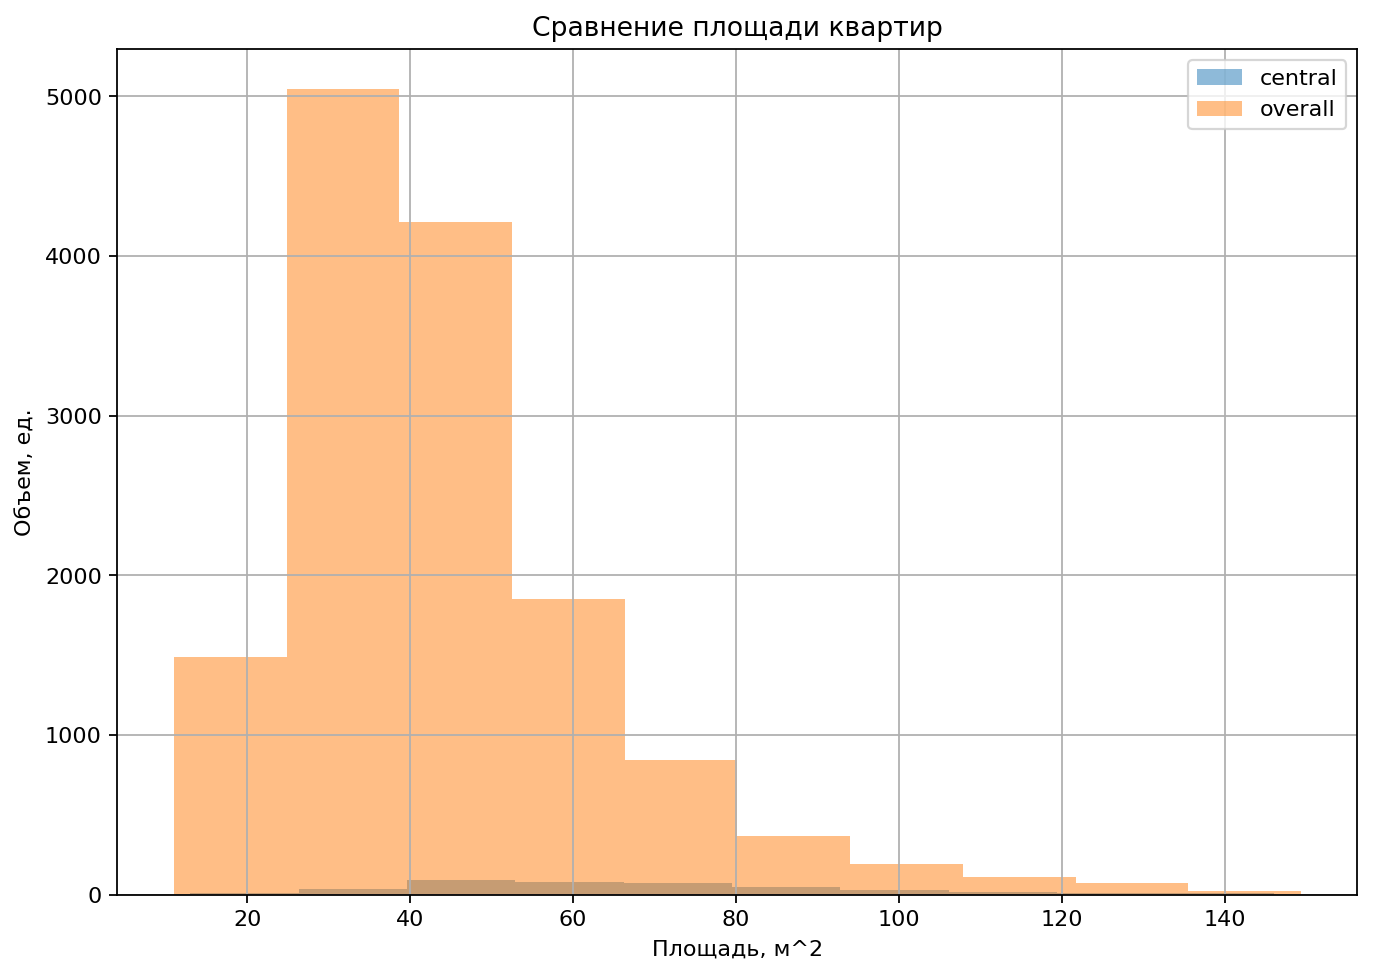

count    396.000000
mean      67.078055
std       25.683703
min       13.035698
25%       46.625000
50%       62.735675
75%       82.025000
max      146.000000
Name: total_area, dtype: float64

In [66]:
compare_hist(central['total_area'], wip_data['total_area'],
             hist_title="Сравнение площади квартир", hist_xlabel="Площадь, м^2")


central['total_area'].describe()

In [67]:
wip_data['total_area'].describe()

count    14199.000000
mean        44.391670
std         19.217275
min         11.000000
25%         30.000000
50%         40.600000
75%         52.121396
max        149.350027
Name: total_area, dtype: float64

По сравнению с общими данными, в центре и медиана, и среднее значение площади - больше. На графике видно, что наиболее популярный вариант площади в общем - от 20 до 50 метров. А для центральных квартир этот диапазон составляет 40-80 метров.

#### Стоимость

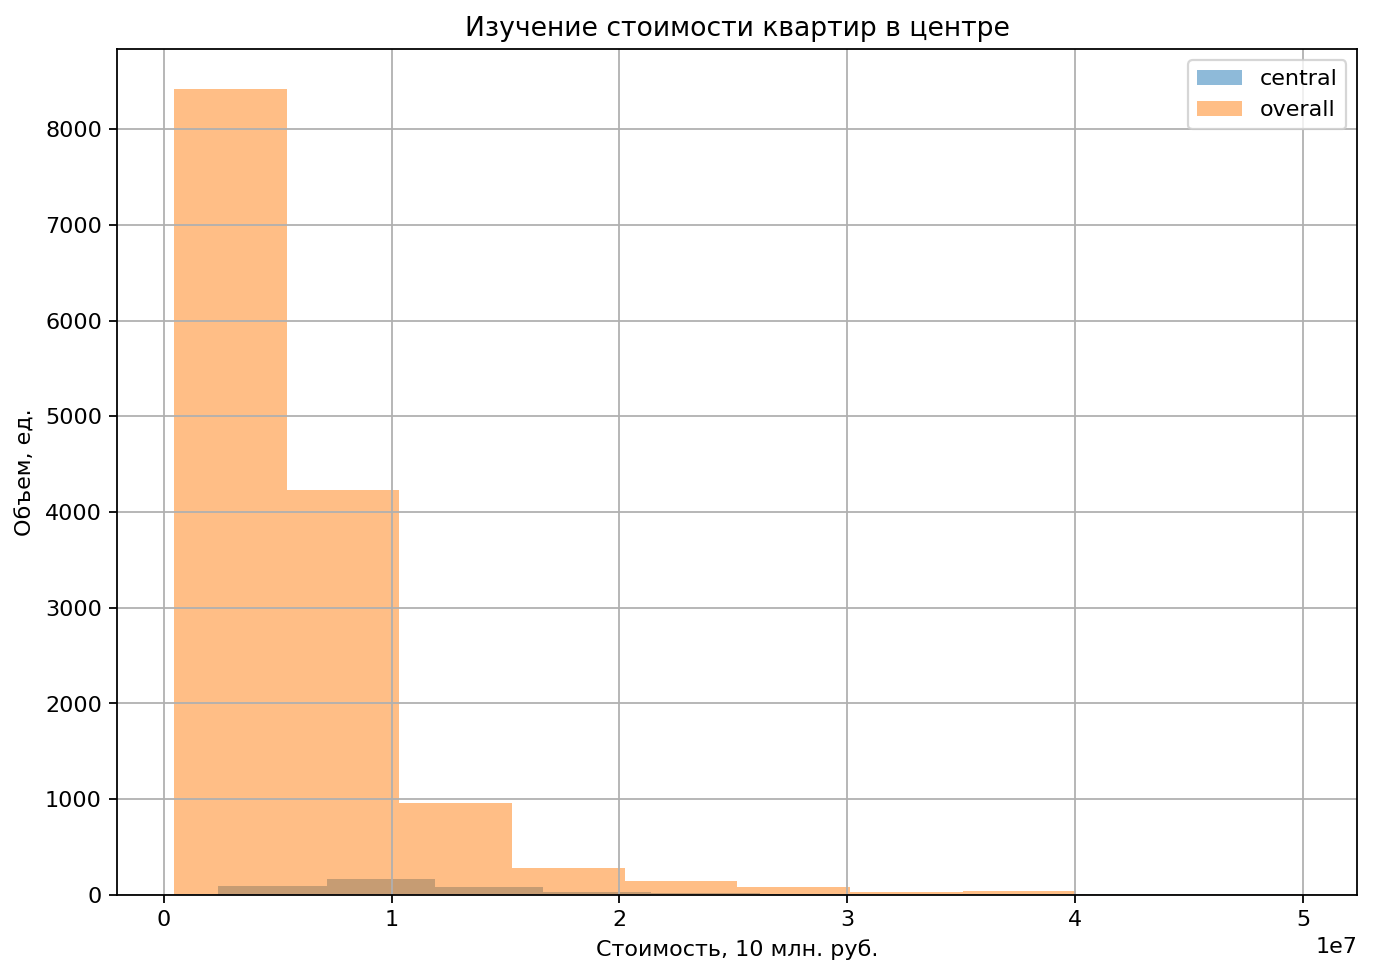

count    3.960000e+02
mean     1.169172e+07
std      6.673473e+06
min      2.400000e+06
25%      7.437500e+06
50%      9.572500e+06
75%      1.399250e+07
max      4.990000e+07
Name: last_price, dtype: float64

In [68]:
compare_hist(central['last_price'], wip_data['last_price'],
             hist_title="Изучение стоимости квартир в центре", hist_xlabel="Стоимость, 10 млн. руб.")

central['last_price'].describe()

In [69]:
wip_data['last_price'].describe()

count    1.419900e+04
mean     6.097466e+06
std      4.729409e+06
min      4.500000e+05
25%      3.550000e+06
50%      4.800000e+06
75%      6.900000e+06
max      4.990000e+07
Name: last_price, dtype: float64

По стоимости квартиры имеем следующее: 

Медиана для квартир в центре в два раза больше, чем для квартир в общем. Минимальная стоимость квартиры отличается более чем на 2 миллиона рублей. 

При этом максимальная стоимость квартиры наблюдается также в центре. 

#### Число комнат

In [70]:
plt.figure(figsize=(16,9))
display(central.pivot_table(index='rooms', values='last_price', aggfunc=['count','median', 'mean']))
plt.show()

central['rooms'].describe()

,count,median,mean
,last_price,last_price,last_price
rooms,,,
0,2,5700000.0,5.700000e+06
1,32,5450000.0,9.175934e+06
2,121,8370000.0,9.960884e+06
3,132,9900000.0,1.218926e+07
4,78,12000000.0,1.323696e+07
5,31,13180000.0,1.542447e+07


<Figure size 1152x648 with 0 Axes>

count    396.000000
mean       2.871212
std        1.081995
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: rooms, dtype: float64

Не строя график, но лишь смотря на значения по 'count' видим, что в центре количество однокомнатных квартир гораздо меньше, чем по всему Петрубргу + области. В общем виде больше всего именно однокомнатных квартир. Здесь же есть перекос в сторону двух- и трёхкомнатные квартиры. Также наблюдается большое количество четырёхкомнатных квартир.

По стоимости наблюдается такая же закономерность, как и в общем случае, - чем больше комнат, тем больше стоимость квартиры.

#### Высота потолков

,median,mean,count
,last_price,last_price,last_price
ceiling_height,,,
2.50,8600000.0,1.128889e+07,9
2.55,2400000.0,2.400000e+06,1
2.60,8750000.0,8.948180e+06,5
2.63,6650000.0,6.650000e+06,1
2.65,7200000.0,7.200000e+06,2
...,...,...,...
4.25,11500000.0,1.150000e+07,1
4.30,9350000.0,9.350000e+06,1


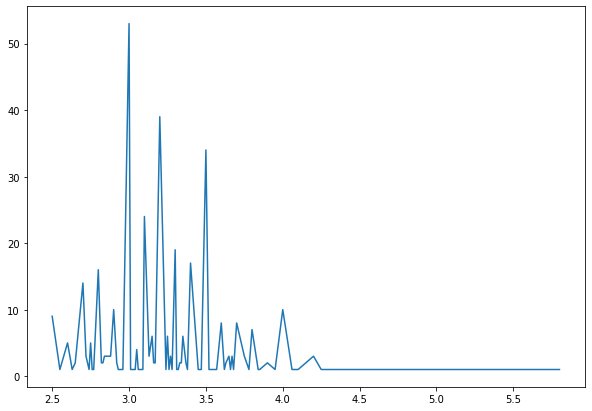

In [71]:
ceiling_pivot = central.pivot_table(index='ceiling_height', values='last_price', aggfunc=['median', 'mean', 'count'])

display(ceiling_pivot)

plt.figure(figsize=(10,7))
plt.plot(ceiling_pivot['count', 'last_price'])
plt.show()

Наиболее популярный тип потолков в центре - 3 метра, когда в общем случае он варьируется - либо 2.5 метра, либо 2.6.

#### Факторы, влияющие на стоимость квартиры

In [72]:
print('Корреляция по Пирсону:')
print('Корреляция с числом квадратных метров - {}'.format(central['last_price'].corr(central['total_area'])))
print('Корреляция с количеством комнат - {}'.format(central['last_price'].corr(central['rooms'])))
print('Корреляция с удаленностью от центра - {}'.format(central['last_price'].corr(central['cityCenters_nearest'])))

Корреляция по Пирсону:
Корреляция с числом квадратных метров - 0.5006751361395286
Корреляция с количеством комнат - 0.2658862644930326
Корреляция с удаленностью от центра - -0.17992825091183545


Значения по корреляции лежат в тех же диапазонах с погрешностью в ±0,1, что и в общем случае. Наибольшая корреляция наблюдается между ценой и числом квадратных метров.

In [73]:
display(central.pivot_table(index='fl_cat', values='last_price', aggfunc=['median', 'count', 'mean']))

,median,count,mean
,last_price,last_price,last_price
fl_cat,,,
другое,10580800.0,235,1.253383e+07
первый,7375000.0,56,9.791034e+06
последний,9000000.0,105,1.082070e+07


В данном случае прослеживается та же закономерность, что и в общем случае - самые дешевые объявления - с квартирами, находящимися на 1-ом этаже, а самые дорогие - с квартирами не на первом и не на последнем этаже.

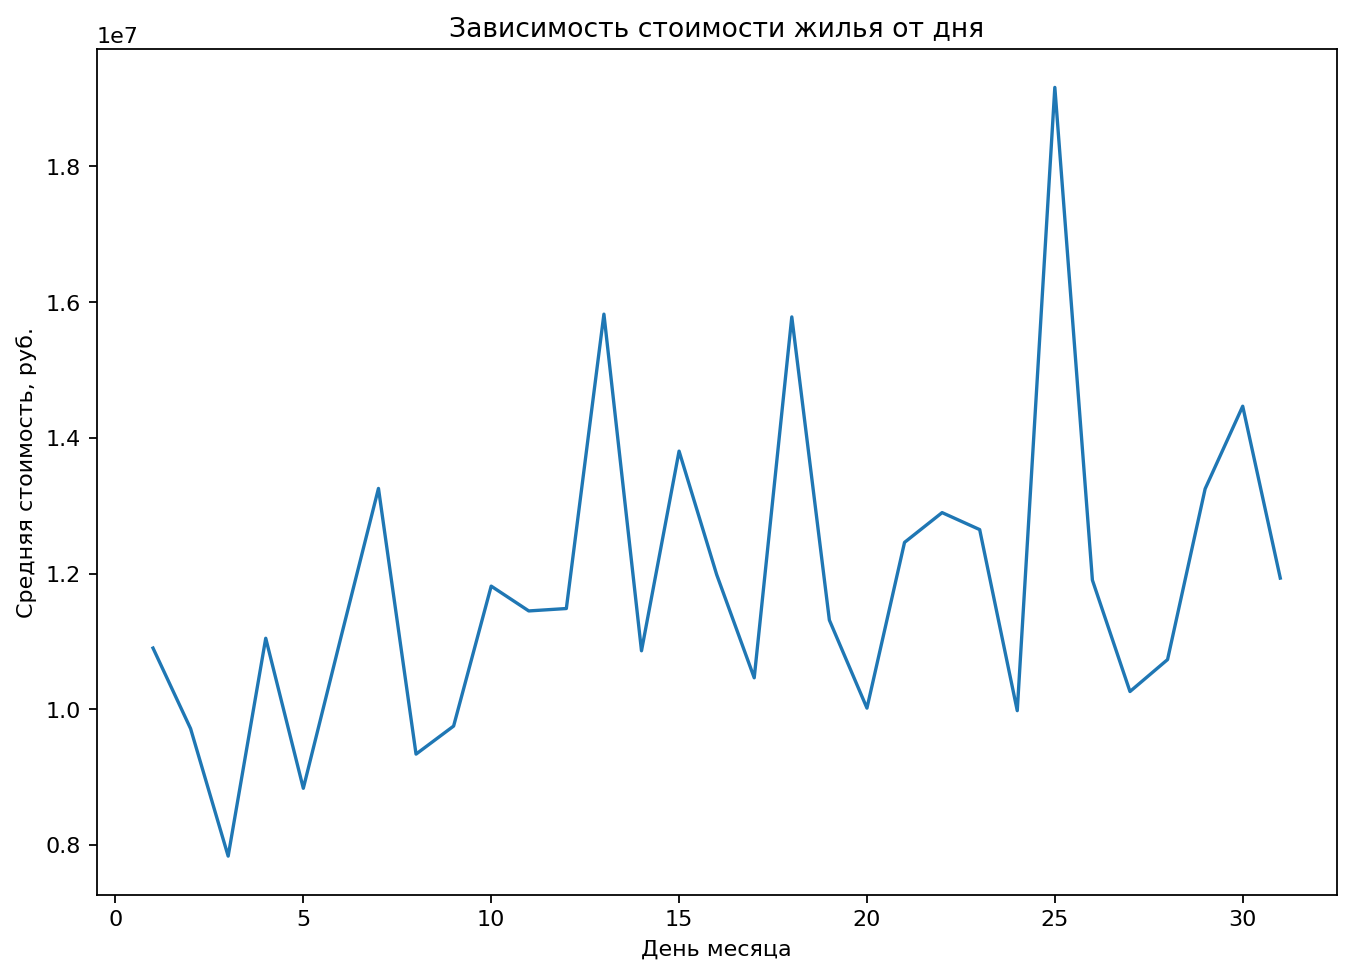

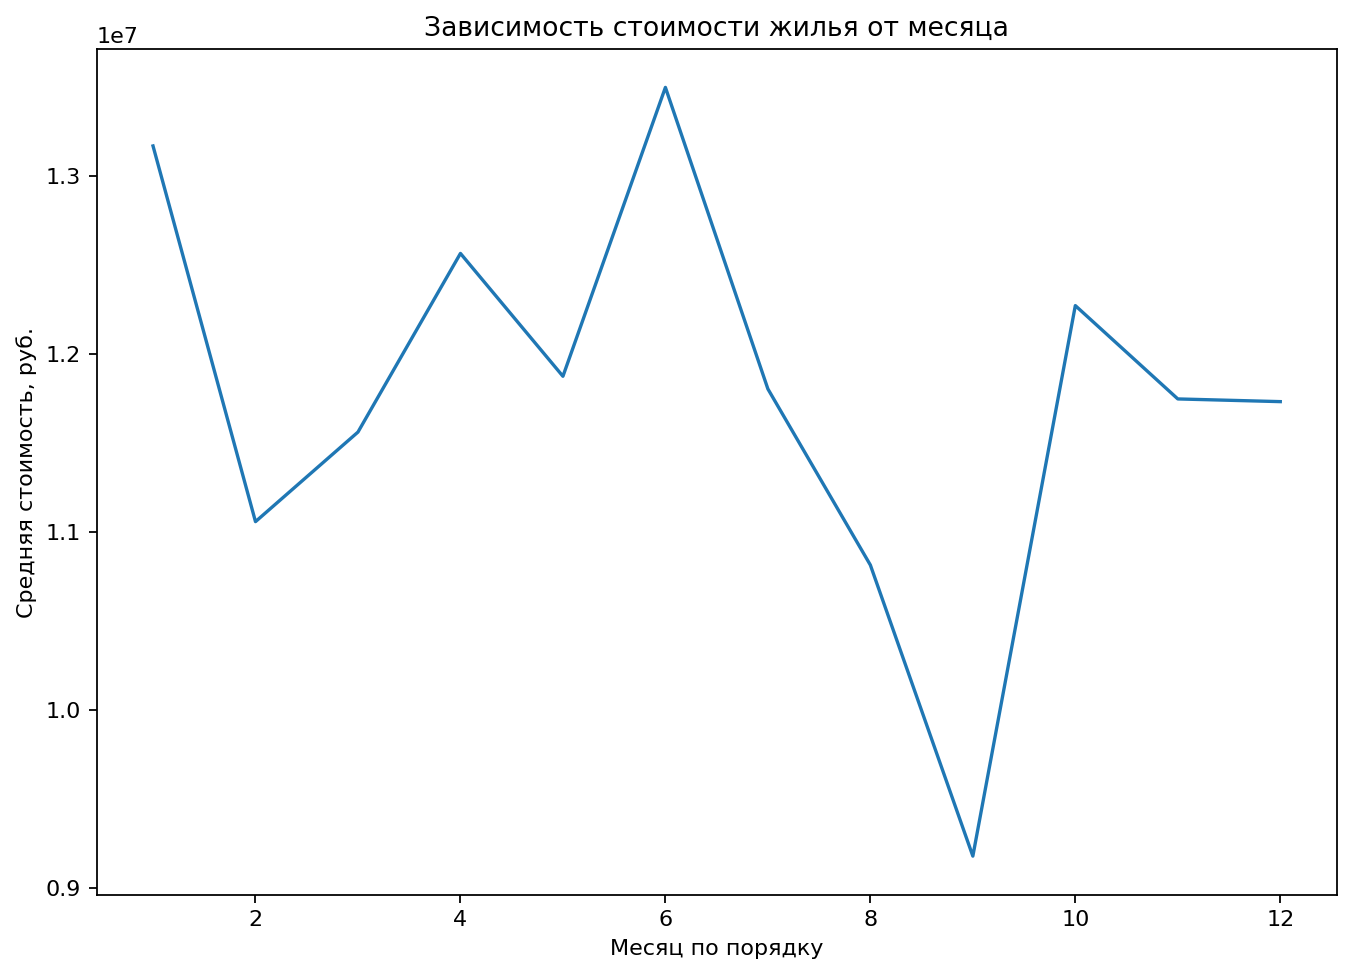

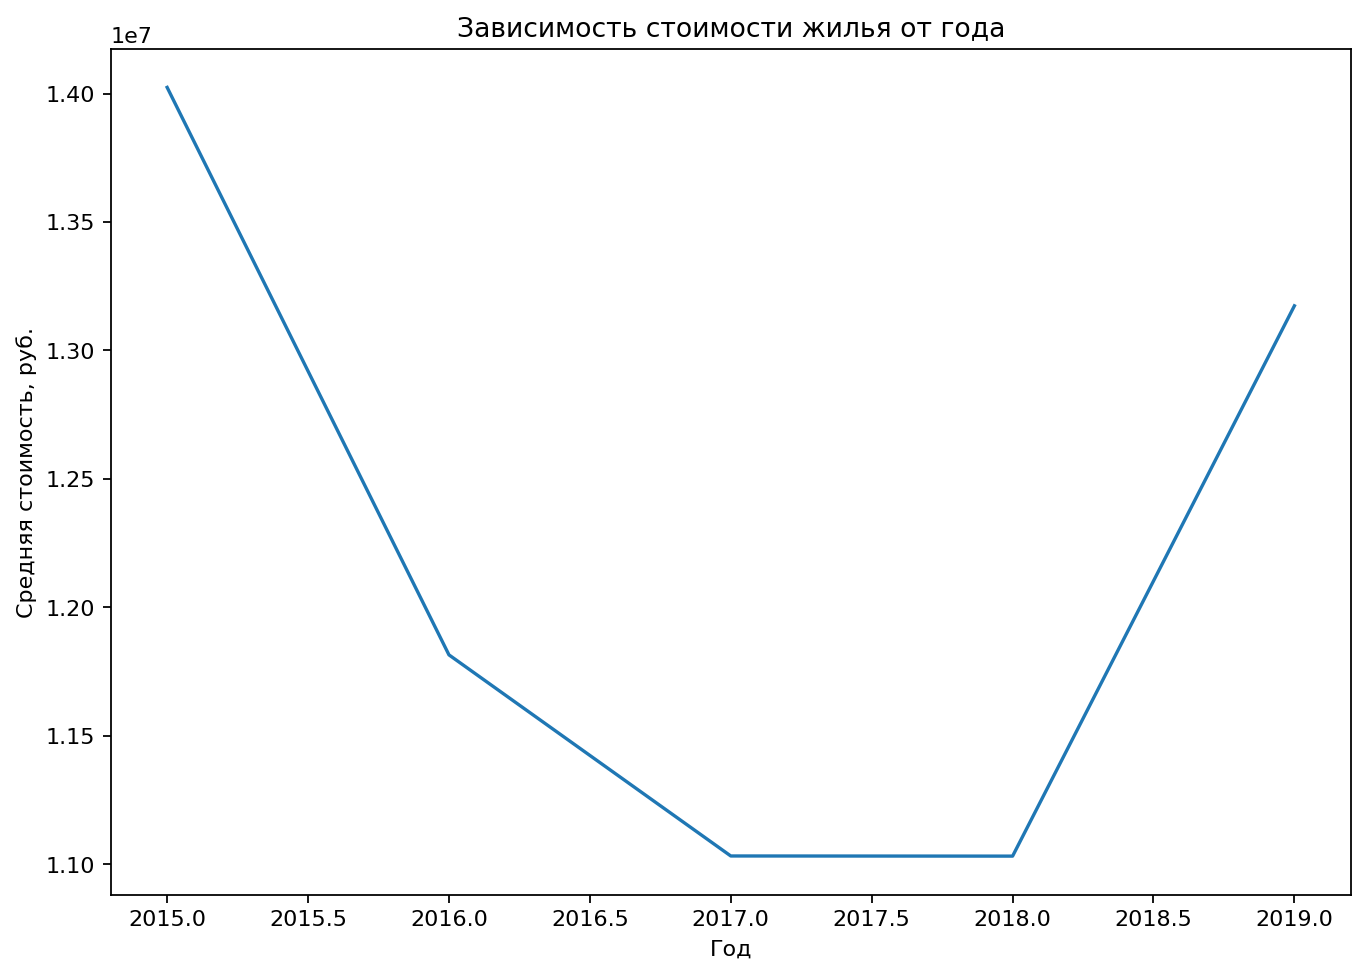

In [74]:
dmy_analysis(central)

По стомости реализации квартир/апартаментов в год - тенденция на снижение совпадает с описанной ранее.

В это же время наибольшей стоимости реализации квартир достигают в феврале, апреле, августе и декабре. В общем случае динамика была немного другой.

По дням видны пиковые значения в 4 и 20 числах, что очень похоже на график выплаты авансов и зарплат (но не имеет отношения к продаже квартир).

Влияние стоимости квартиры на удаленность из центра рассматривалась в прошлом задании, именно из него было выведено, что центральная область занимает примерно 3 километра, и цена в рамках удаления от неё постепенно падает.

#### Выводы 

В результате рассмотрения квартир, расположенных в центре, я пришел к следующим выводам: 

Средняя стоимость квартиры в центре гораздо выше, чем в общем по Петербургу + области. Потолки выше, а комнат на квартиру - больше. 
При этом сохраняются те же закономерности, что наблюдались и в общем случае. 

## Шаг 5. Общий вывод

В результате проведенного исследования я сделал следующие выводы:

Наибольшую стоимость имеют квартиры, расположенные в центре Санкт-Петербурга, желательно с несколькими комнатами и не на первом и последнем этаже. 

Разница в ценообразовании квартир в центре и квартир в общем - не так велика. Основным фактором, влияющим на стоимость квартиры, является площадь. При этом остальные факторы не так сильно влияют на стоимость.

Также важно отметить, что в таком исследовании мы предполагаем, что качество жилых площадей будет более-менее одинаковым. Подразумевается один и тот же вид ремонта, состояние мебели, кухни, ванной и тому подобное. 
Довольно тяжело в рамках датасета определить, какое жилье относится к эконом классу, какое к бизнесс, а какое к люкс. А ведь качество интерьера должно влиять не меньше, чем общая площадь!

Объявление реализуется в среднем 200 дней. После этого срока имеет смысл оповестить пользователя, разместившего объявление, с указанием, что его квартира как-то медленно продаётся (не такими грубыми словами, конечно).
